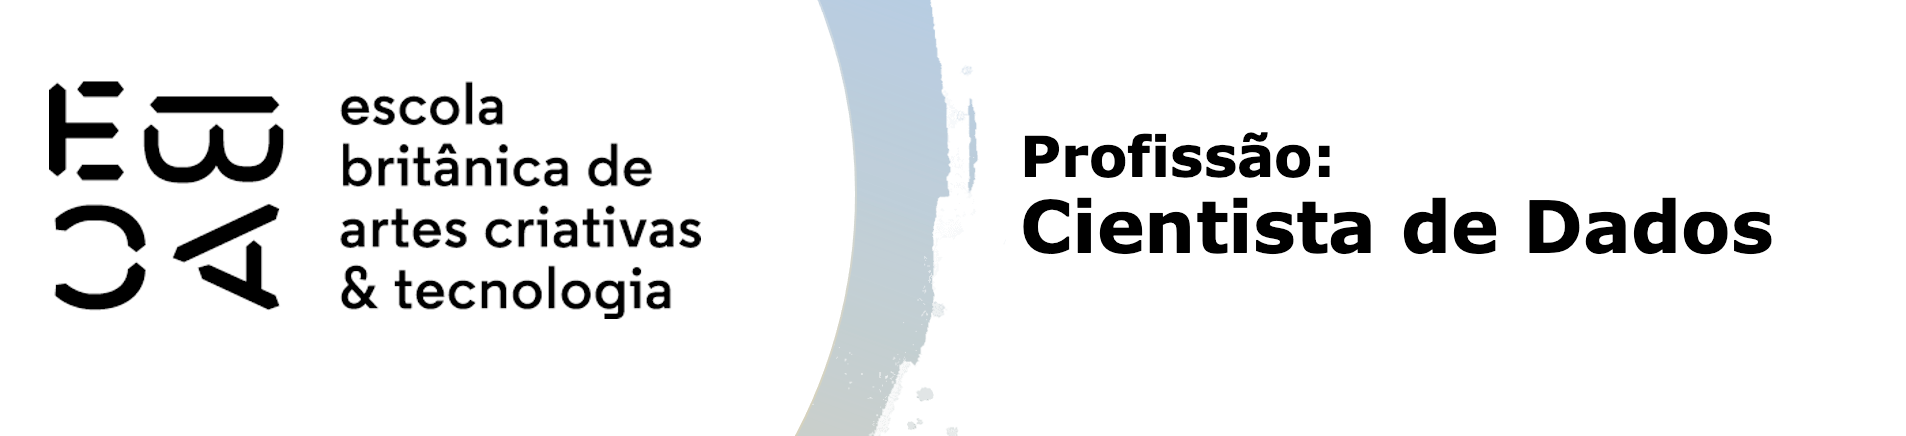

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Import bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t, ks_2samp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d

from sklearn.metrics import accuracy_score
from joblib import dump, load

In [2]:
# Carregando base
df = pd.read_feather('./../36_modulo/data/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
# Obtendo amostra da base para a modelagem, devido ao grande número de instâncias
df_copy = df.sample(frac=.1).copy()

# Convertendo renda para log
df_copy['renda_log'] = np.log(df_copy['renda'])

# Obtendo o valor de mês da data de referência
df_copy['month'] = df_copy['data_ref'].dt.month

# Inserindo dados faltantes com média em tempo de emprego 
df_copy.fillna({"tempo_emprego": np.mean(df_copy['tempo_emprego'])}, inplace=True)

# Removendo index da base
df_copy.drop('index', axis=1, inplace=True)
df_copy.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month
138912,2015-03-01,F,N,S,2,Assalariado,Superior incompleto,Casado,Casa,29,5.958904,4.0,5713.75,True,8.650631,3
85474,2015-02-01,M,S,N,0,Empresário,Médio,Casado,Casa,40,1.197260,2.0,1467.14,False,7.291070,2
630151,2016-01-01,F,N,N,1,Assalariado,Médio,Viúvo,Casa,53,1.295890,2.0,1214.39,False,7.101997,1
95328,2015-02-01,F,N,S,0,Empresário,Médio,Casado,Casa,62,7.619178,2.0,9044.93,False,9.109960,2
539789,2015-11-01,F,N,N,1,Empresário,Superior completo,Casado,Casa,30,4.331507,3.0,6829.06,False,8.828942,11


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Instanciando variável com a base de validação
df_valid = df_copy[df_copy['data_ref'] >= '2015-12-01']

# Instanciando variável com a base de teste
df_train = df_copy[df_copy['data_ref'] < '2015-12-01']
print("Treino:")
print(f"Início -> {df_train['data_ref'].min()} \nFim    -> {df_train['data_ref'].max()}")
print()
print("Validação:")
print(f"Início -> {df_valid['data_ref'].min()} \nFim    -> {df_valid['data_ref'].max()}" )

Treino:
Início -> 2015-01-01 00:00:00 
Fim    -> 2015-11-01 00:00:00

Validação:
Início -> 2015-12-01 00:00:00 
Fim    -> 2016-03-01 00:00:00


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
# Descrição da base
print("Treino:")
print(f"Nùm. linhas : {df_train.shape[0]:,.0f}".replace(",","."))
print(f"Nùm. colunas: {df_train.shape[1]:,.0f}".replace(",","."))
print()
print("Validação:")
print(f"Nùm. linhas  : {df_valid.shape[0]:,.0f}".replace(",","."))
print(f"Nùm. colunas : {df_valid.shape[1]:,.0f}".replace(",","."))

Treino:
Nùm. linhas : 55.055
Nùm. colunas: 16

Validação:
Nùm. linhas  : 19.945
Nùm. colunas : 16


In [6]:
# Número de linhas para cada mês em data_ref na base de treino
df_train.groupby("month")['data_ref'].count()

month
1     4945
2     5002
3     4947
4     5050
5     4996
6     4994
7     5045
8     5039
9     5018
10    4933
11    5086
Name: data_ref, dtype: int64

In [7]:
# Número de linhas para cada mês em data_ref na base de teste
df_valid.groupby("month")['data_ref'].count()

month
1     4912
2     4972
3     5000
12    5061
Name: data_ref, dtype: int64

In [8]:
# Verificando as classes das variáveis
df_copy.dtypes

data_ref                 datetime64[ns]
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
renda_log                       float64
month                             int32
dtype: object

In [9]:
# Lista com as posições dos gráficos
ax_index = [
    [0,0],[0,1],[0,2],
    [1,0],[1,1],[1,2],
    [2,0],
]
ax_index

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0]]

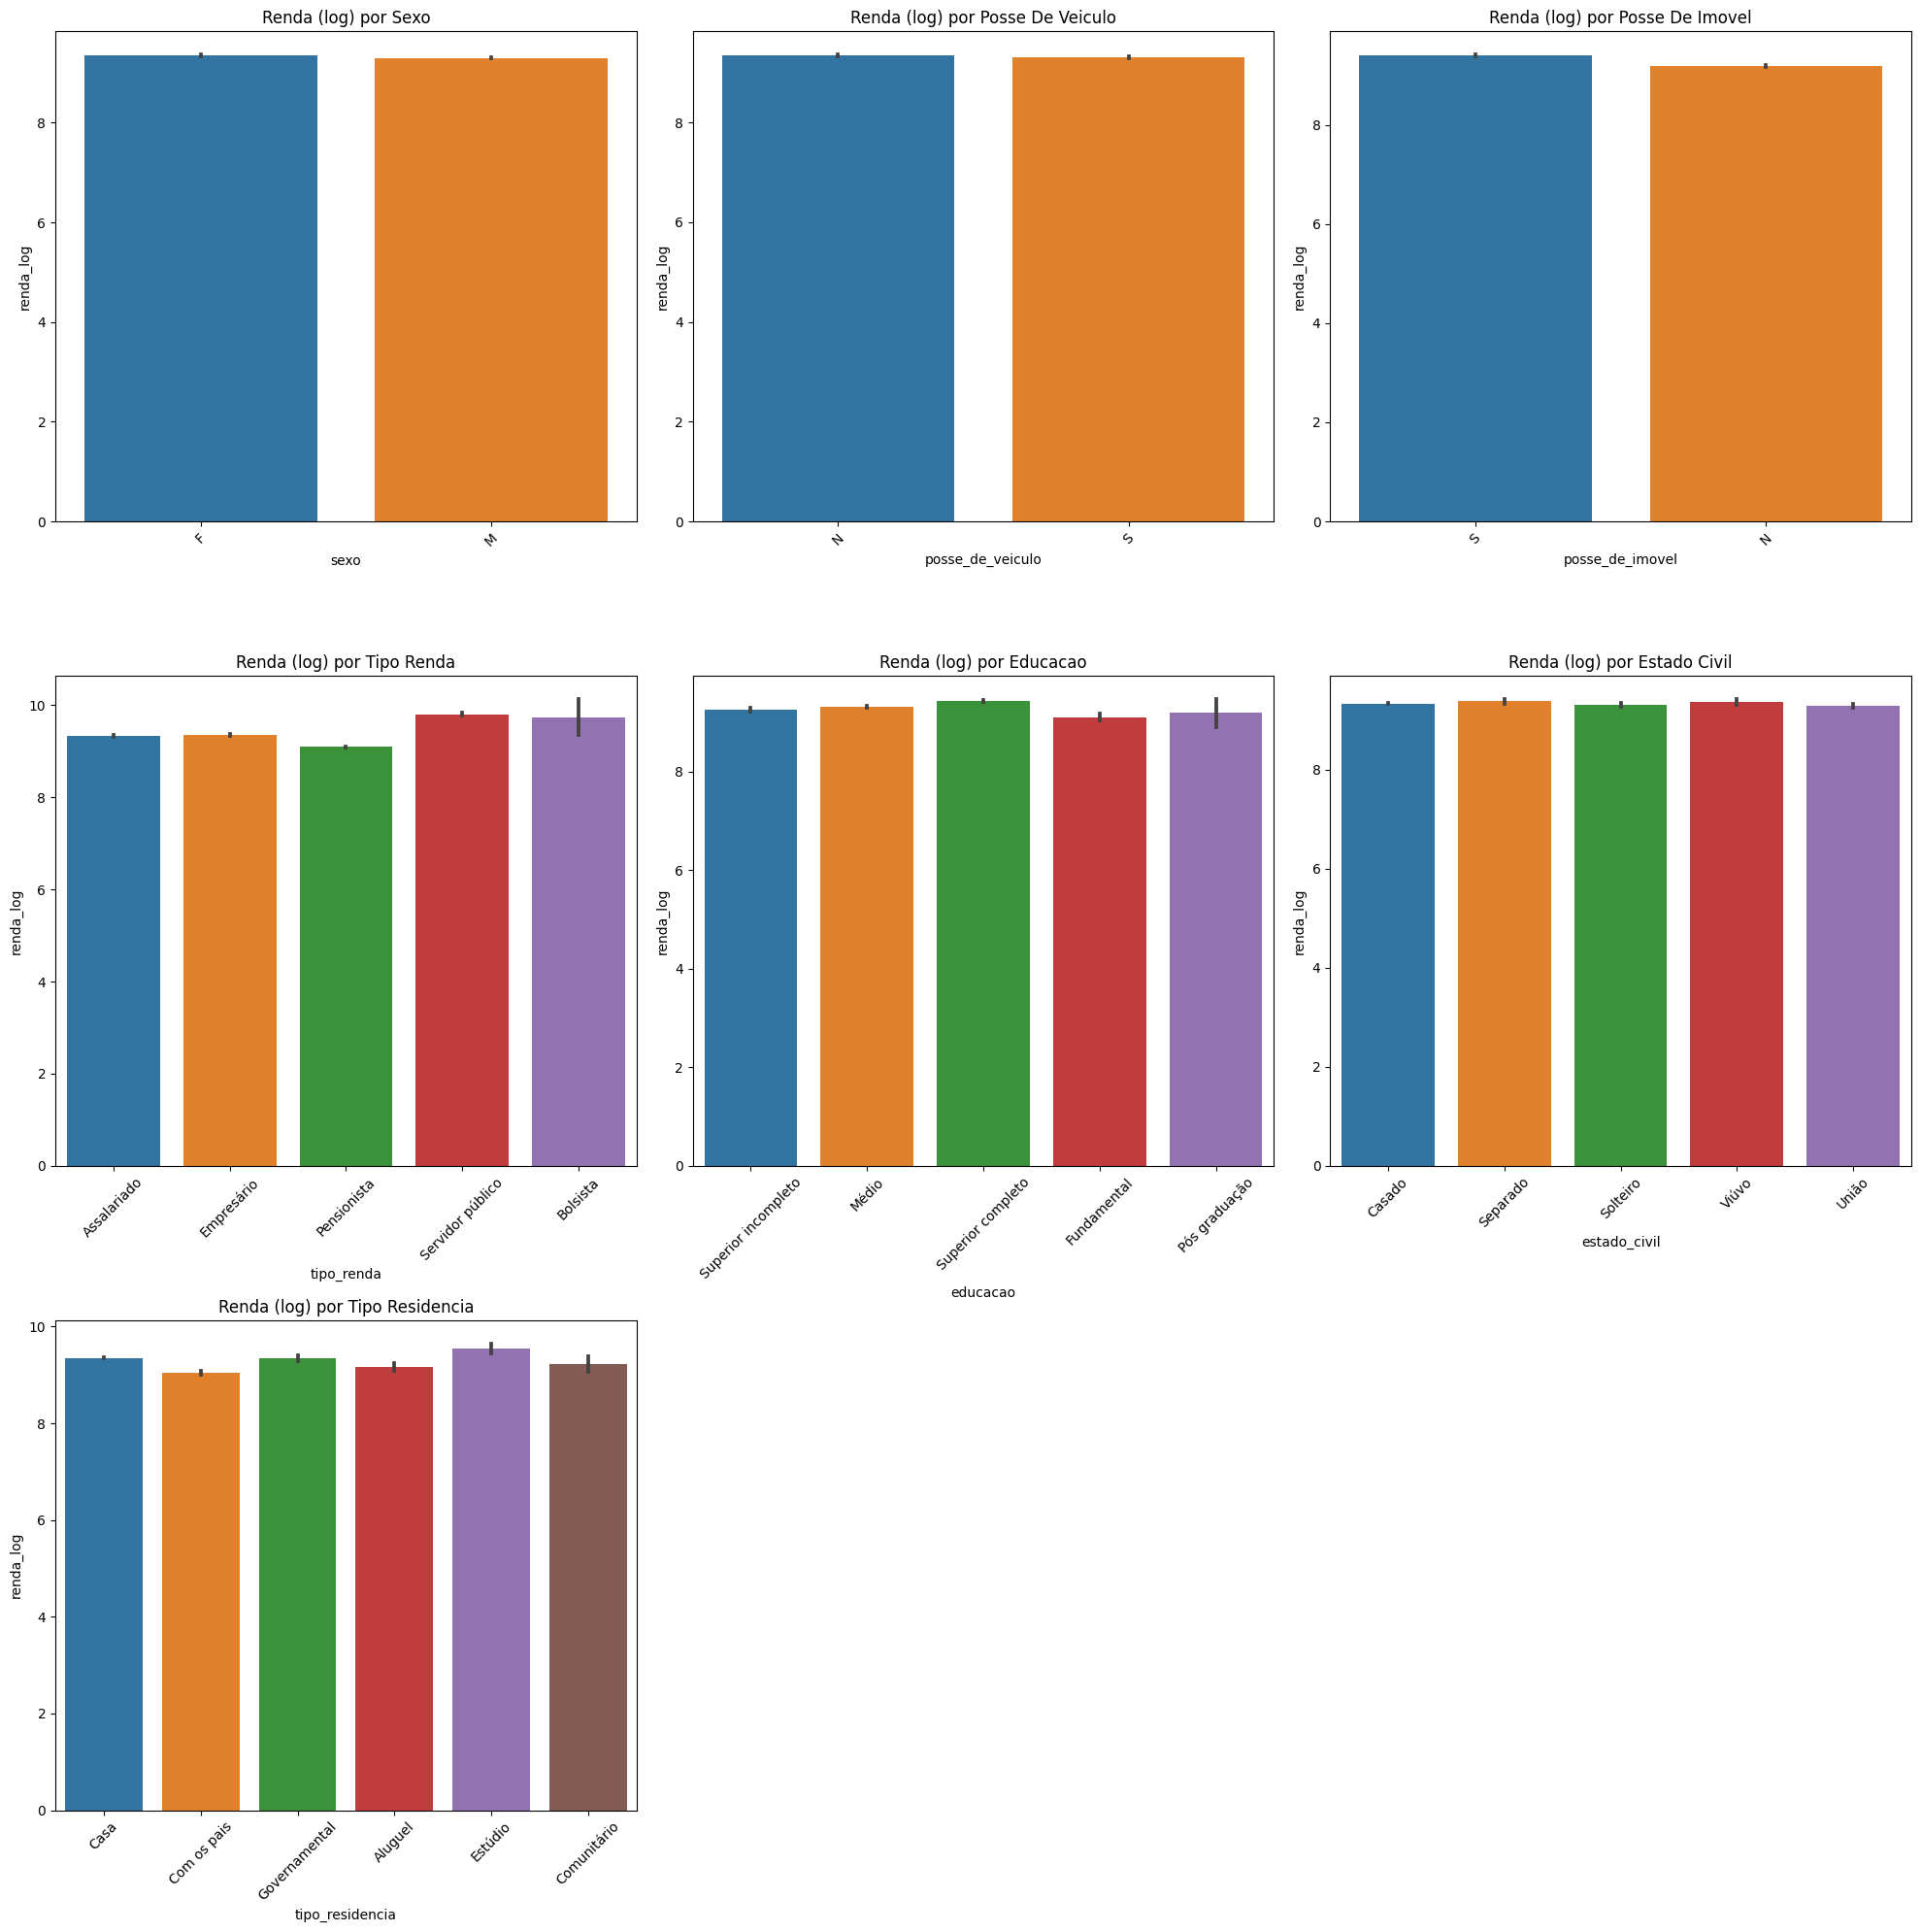

In [10]:
# Análise univariáda de variáveis categóricas, base treino
fig, ax = plt.subplots(3,3, figsize=(20,20))
for k, v in enumerate(df_copy.select_dtypes("object").dtypes.index):
    g = sns.barplot(
        x=v,
        y='renda_log',
        data=df_train,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.show()

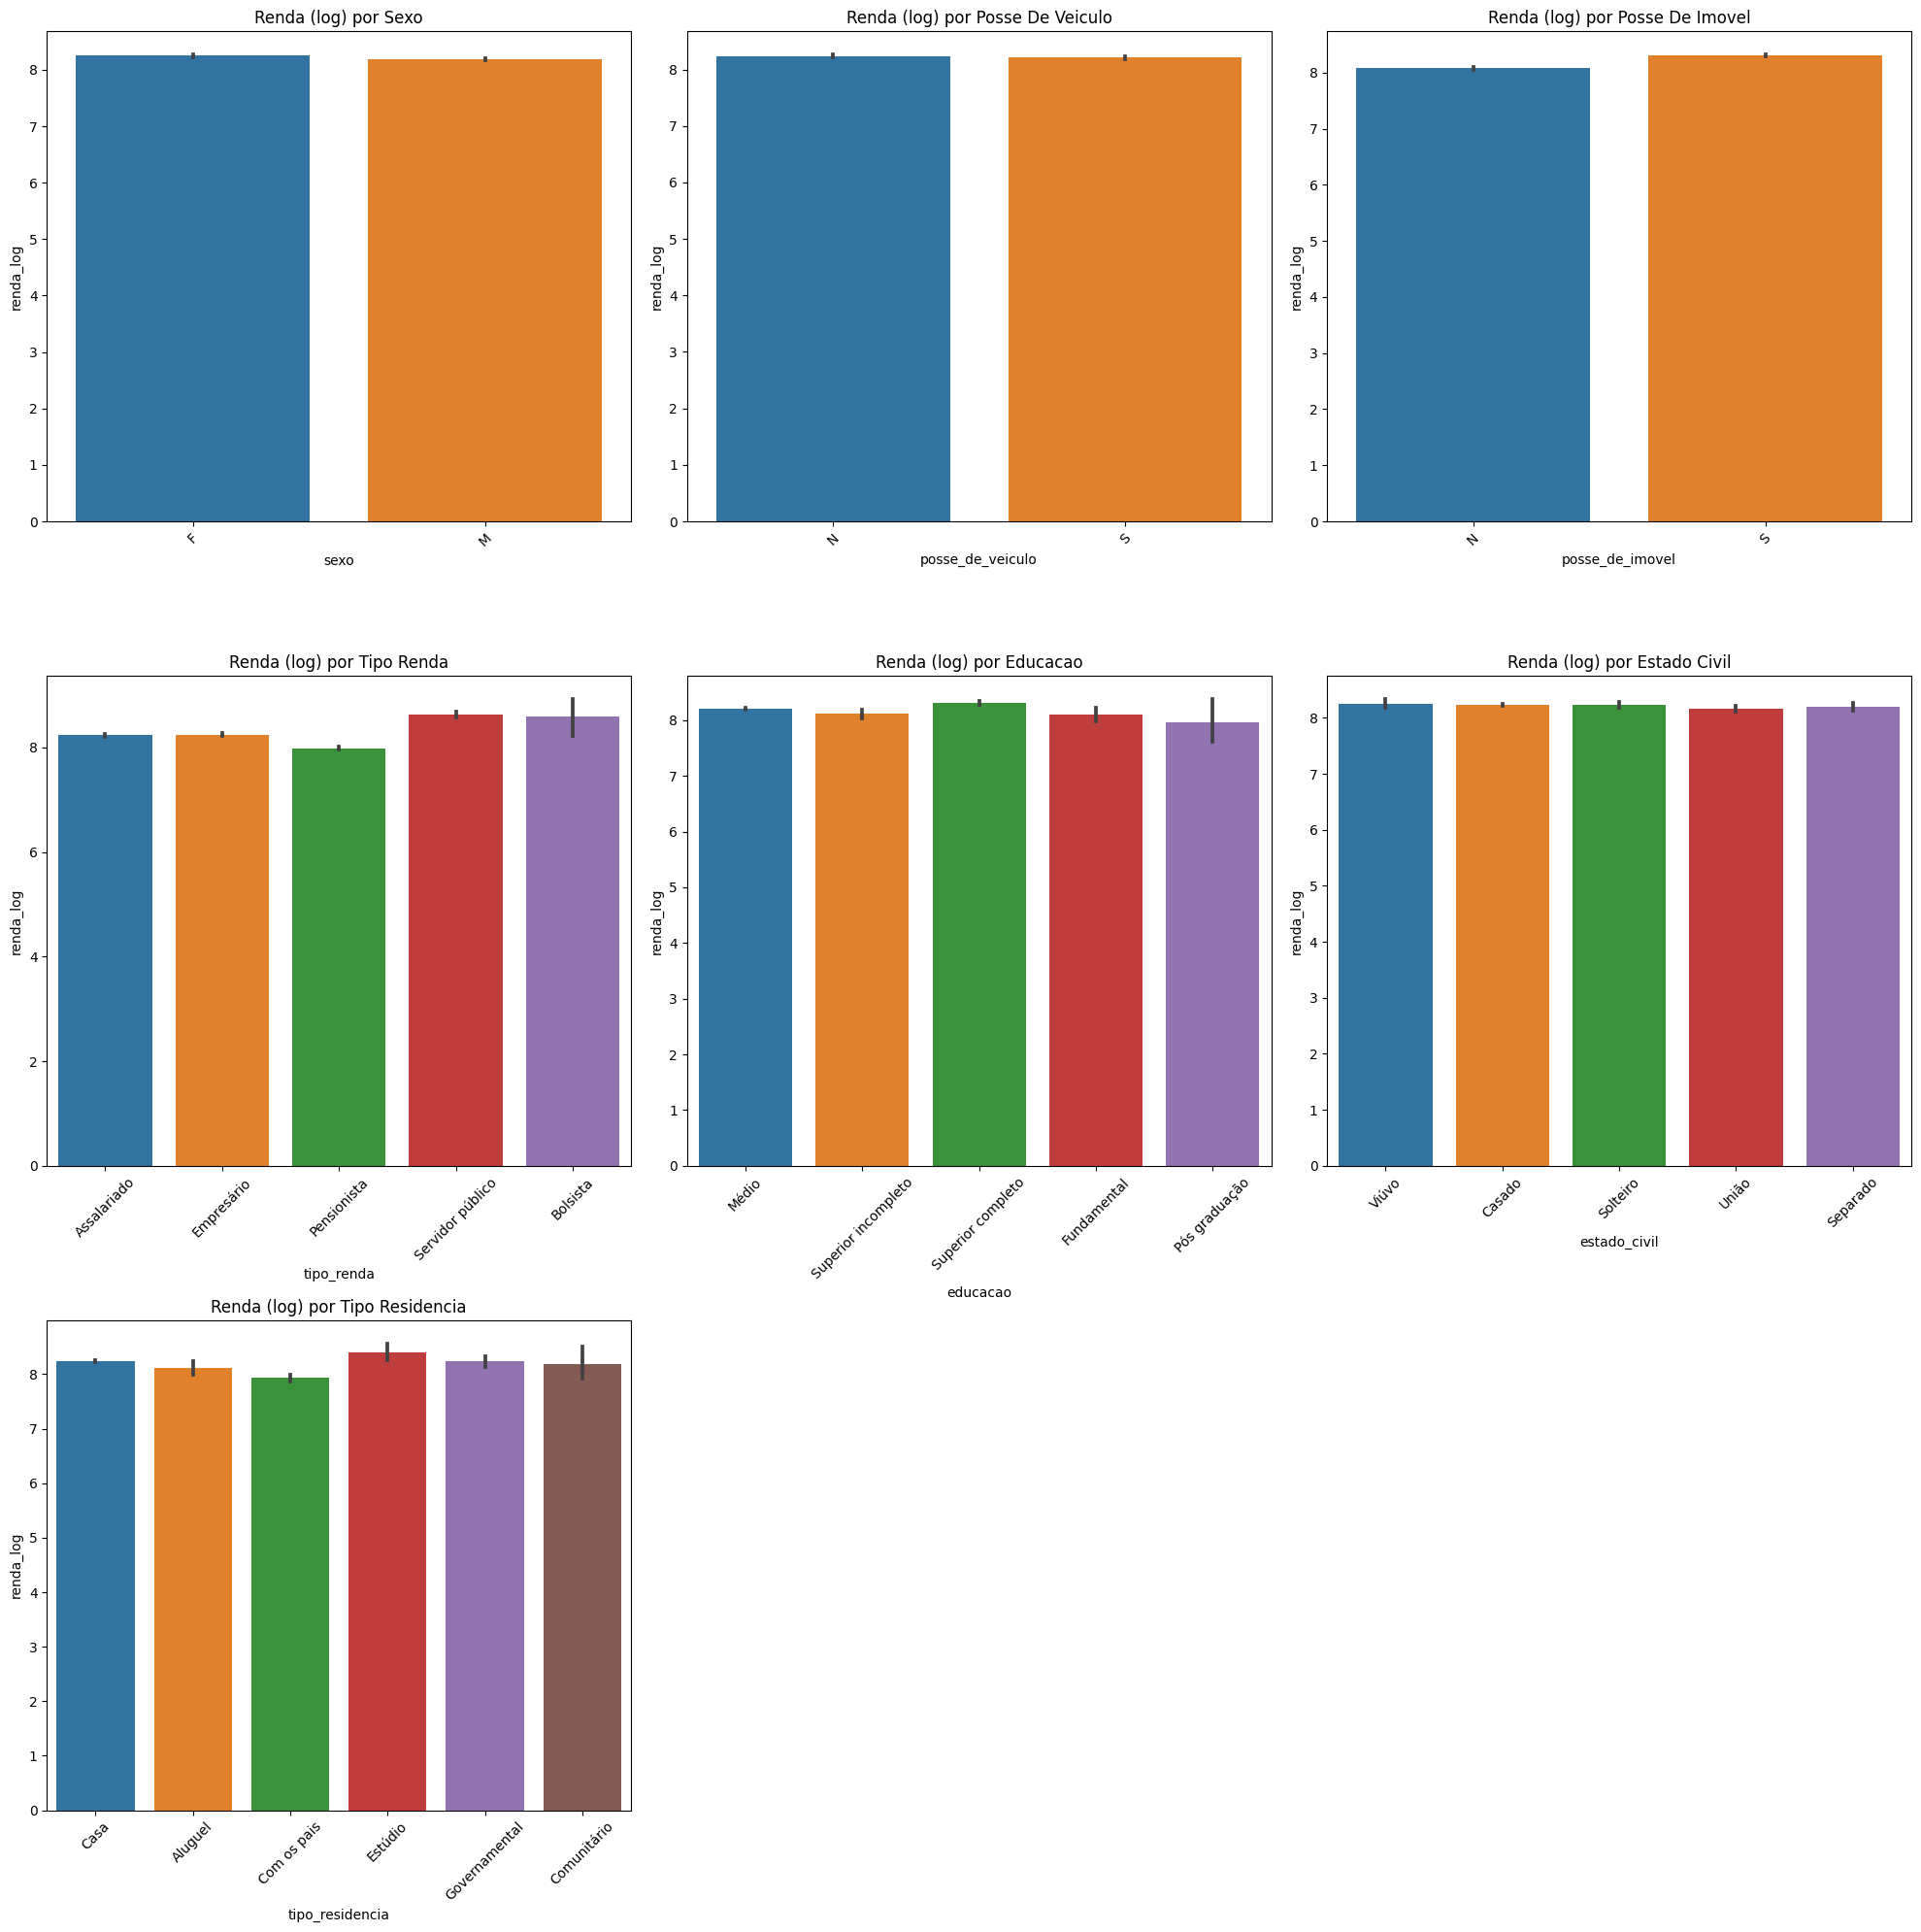

In [11]:
# Análise univariáda de variáveis categóricas, base validação
fig, ax = plt.subplots(3,3, figsize=(20,20))
for k, v in enumerate(df_copy.select_dtypes("object").dtypes.index):
    g = sns.barplot(
        x=v,
        y='renda_log',
        data=df_valid,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.show()

In [12]:
# Variáveis contínuas e discretas
df_train.select_dtypes(["float64","int32"]).dtypes.index

Index(['tempo_emprego', 'qt_pessoas_residencia', 'renda', 'renda_log',
       'month'],
      dtype='object')

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

<function matplotlib.pyplot.show(close=None, block=None)>

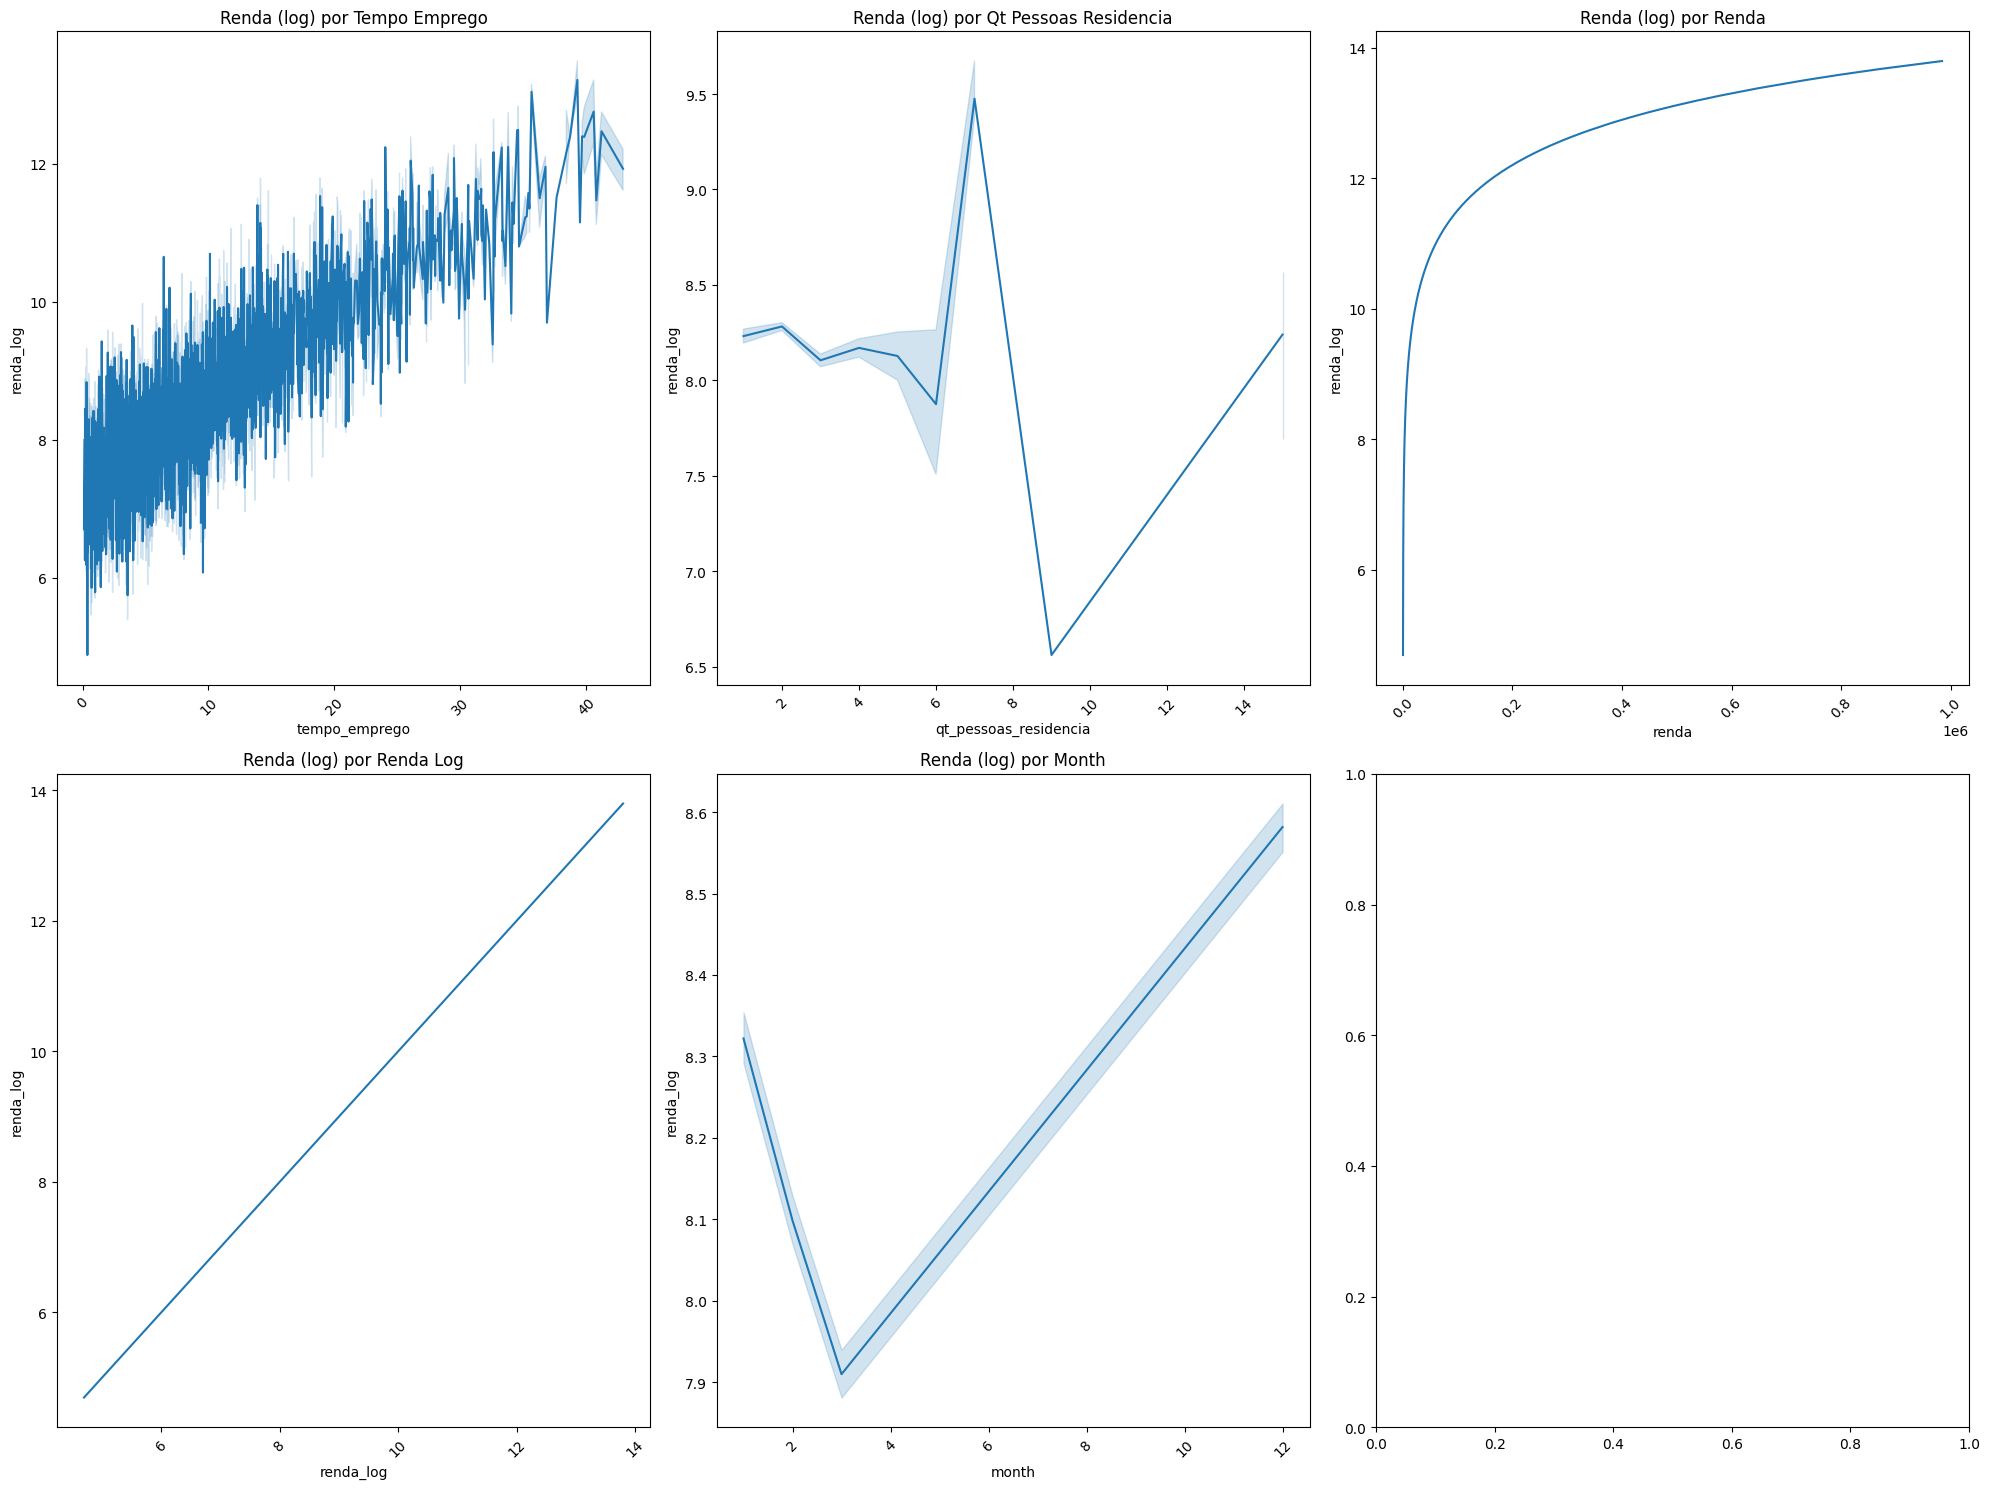

In [13]:
# Análise univariáda de variáveis numéricas, base validação
fig, ax = plt.subplots(2, 3, figsize=(20,15))
for k, v in enumerate(df_train.select_dtypes(["float64","int32"]).dtypes.index):
    g = sns.lineplot(
        x=v,
        y='renda_log',
        data=df_valid.replace([np.inf, -np.inf], np.nan),
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[1,2].set_axis_off()
plt.show

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

<function matplotlib.pyplot.show(close=None, block=None)>

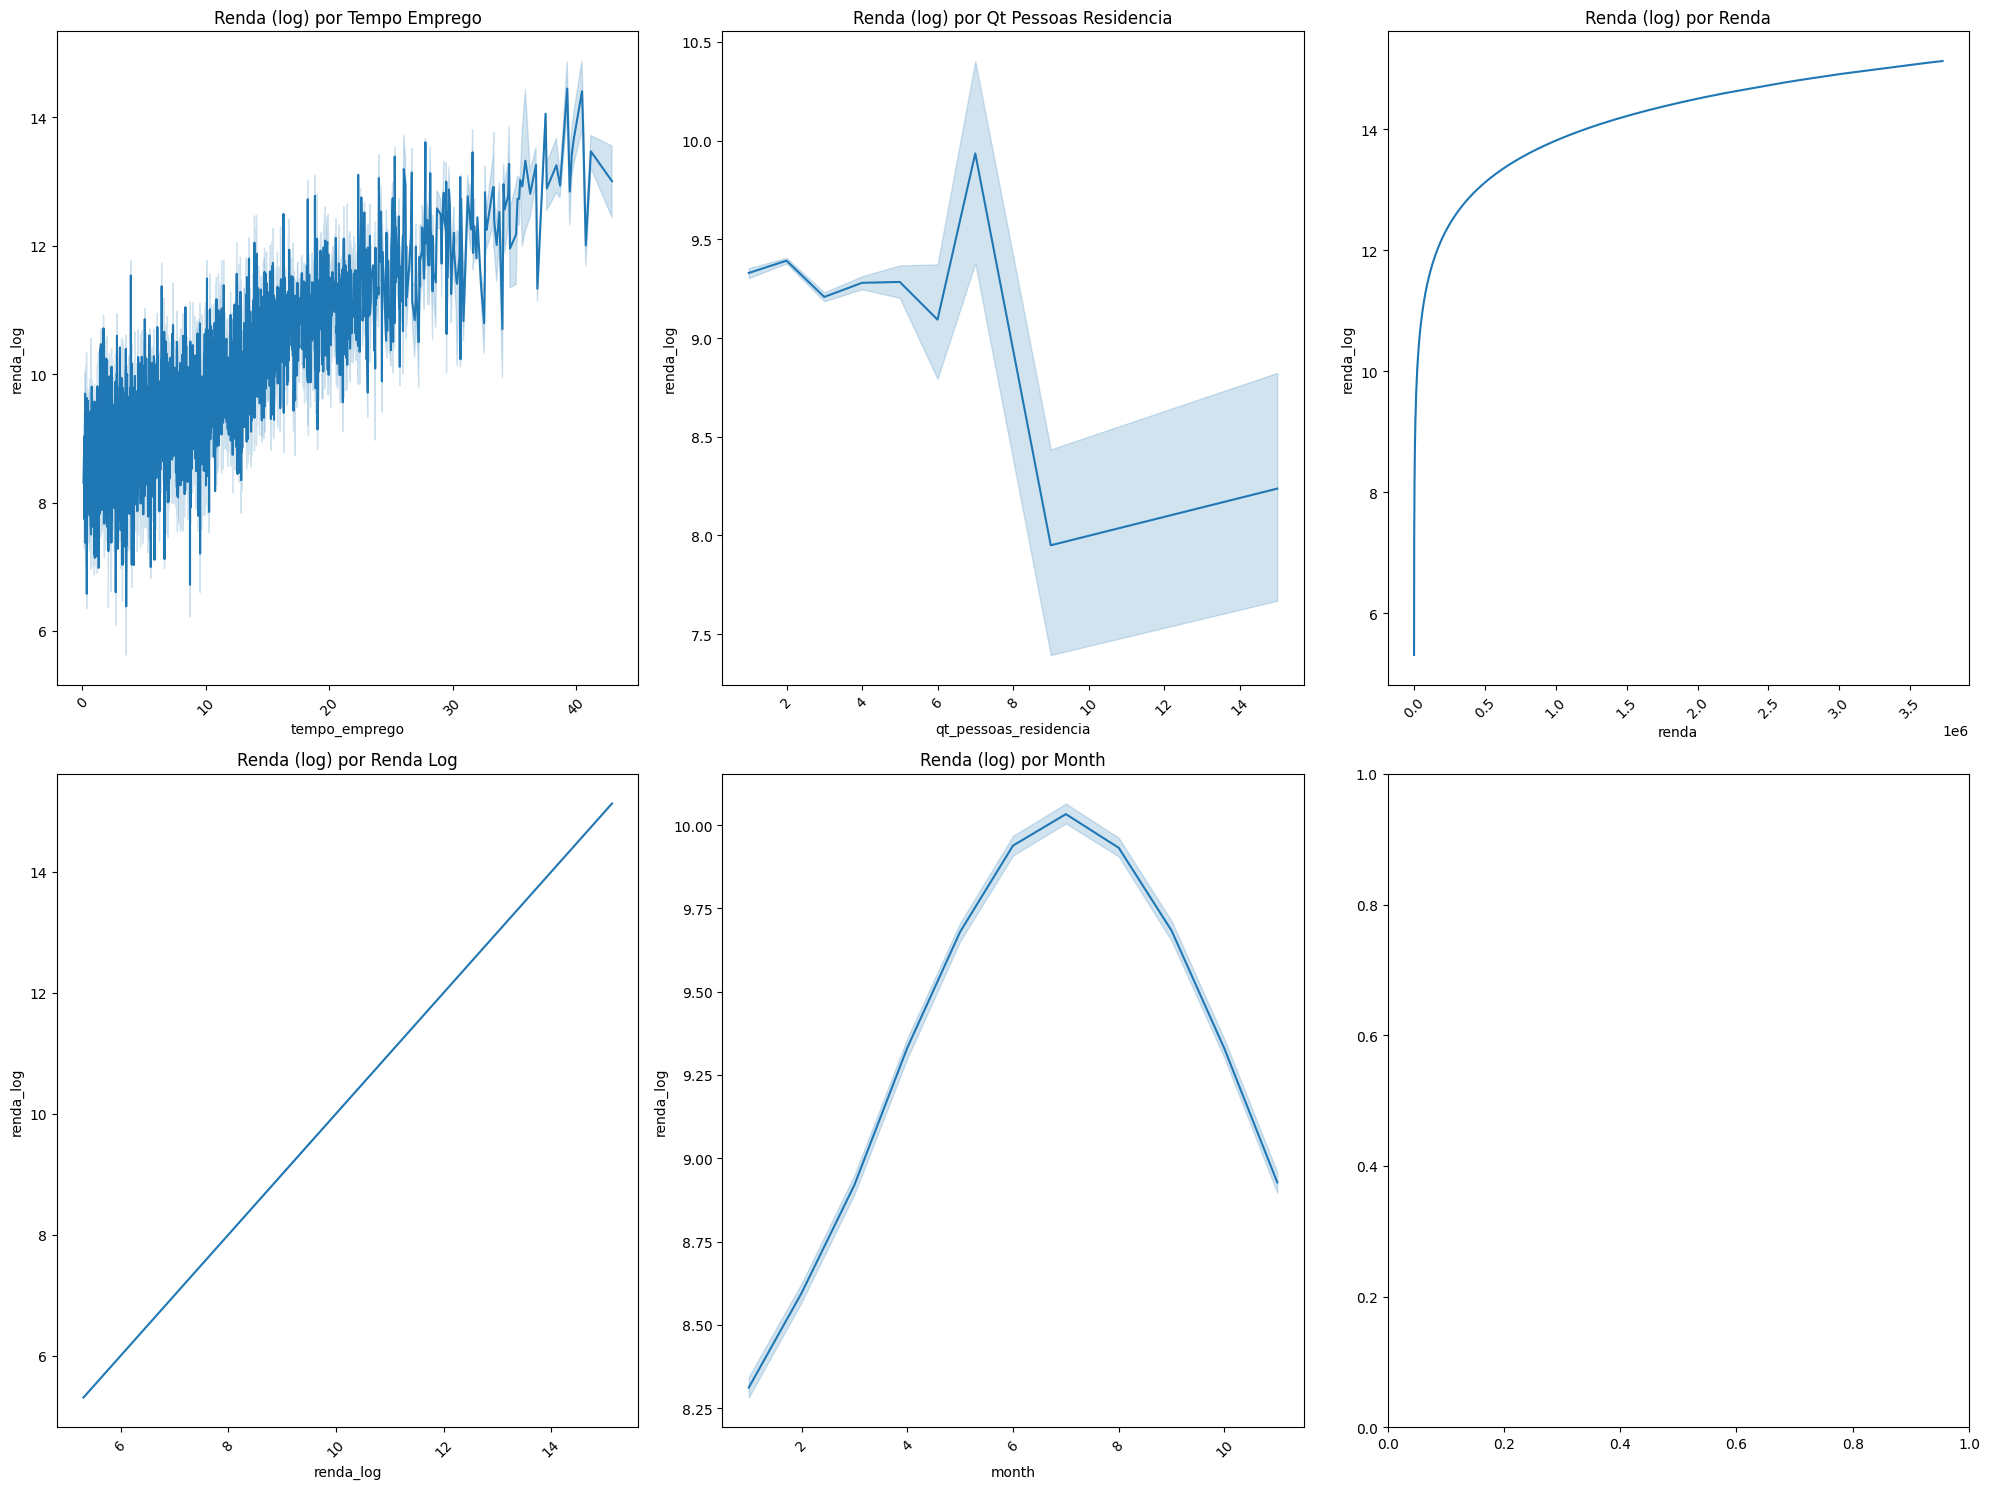

In [14]:
# Análise univariáda de variáveis numéricas, base treino
fig, ax = plt.subplots(2, 3, figsize=(20,15))
for k, v in enumerate(df_train.select_dtypes(["float64","int32"]).dtypes.index):
    g = sns.lineplot(
        x=v,
        y='renda_log',
        data=df_train.replace([np.inf, -np.inf], np.nan),
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[1,2].set_axis_off()
plt.show

## Conclusão
- Observa-se que todas as analises univariadass retornam informações que podem ser consideradas consistentes para a distribuição de valores em relação a variável resposta

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [15]:
# Função de gráfico e calculos WOE
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    _, ax = plt.subplots(2,1, figsize=(20, 8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [16]:
# Variáveis categóricas da base
categorias = df_train.select_dtypes("object").dtypes.index
categorias

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object')

#### Base Teste

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,34953,2235,0.060100,F,37188,0.001232,0.062516,0.057684,-2.749763,-2.707782,-2.793354,0.028591,0.070572,-0.015000
M,16881,986,0.055186,M,17867,0.001708,0.058534,0.051837,-2.840288,-2.777832,-2.906419,-0.061933,0.000523,-0.128065


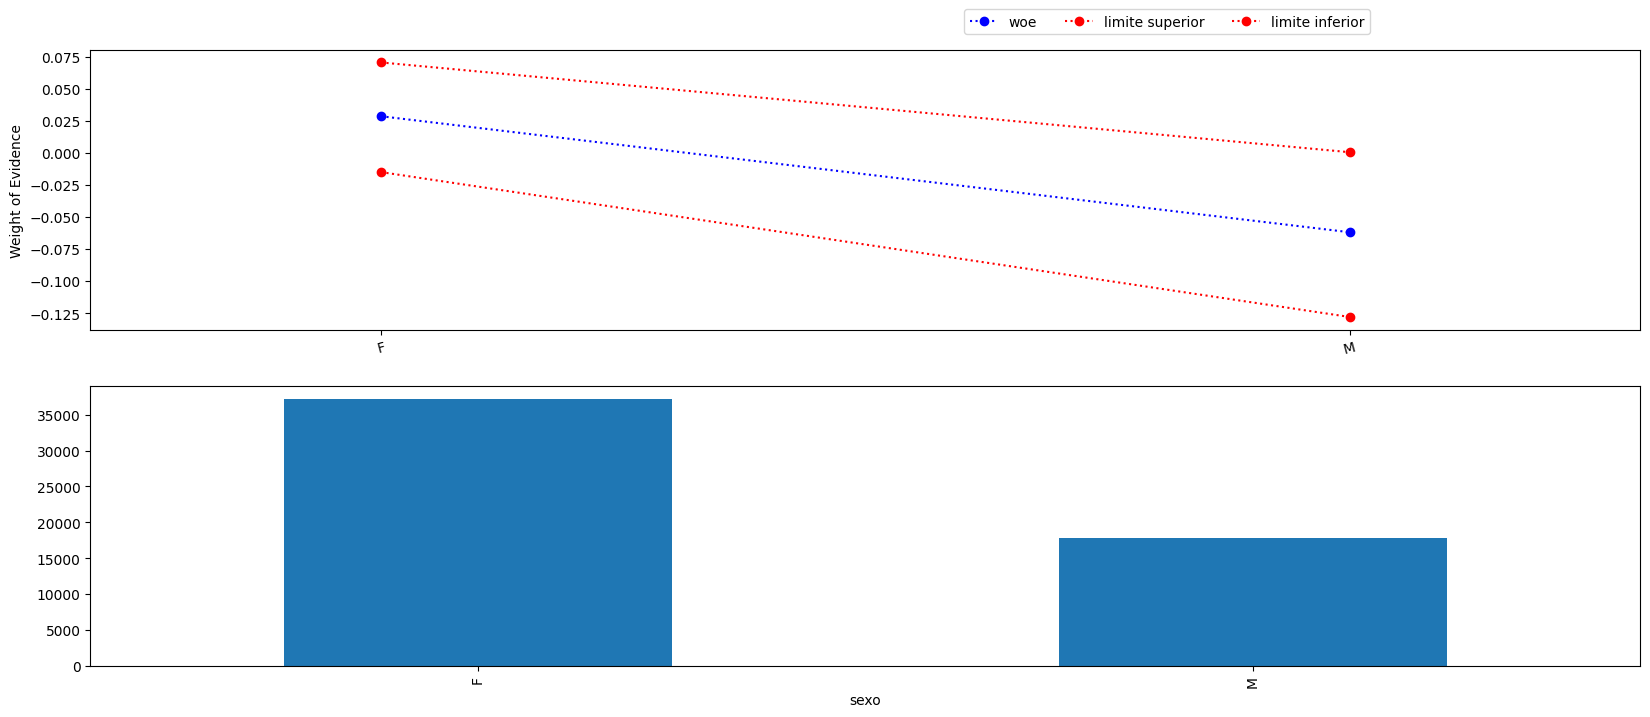

In [17]:
# Sexo
c = 0
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,31652,1974,0.058705,N,33626,0.001282,0.061217,0.056192,-2.774739,-2.730156,-2.821149,0.003615,0.048198,-0.042795
S,20182,1247,0.058192,S,21429,0.001599,0.061327,0.055058,-2.784050,-2.728251,-2.842745,-0.005696,0.050104,-0.064391


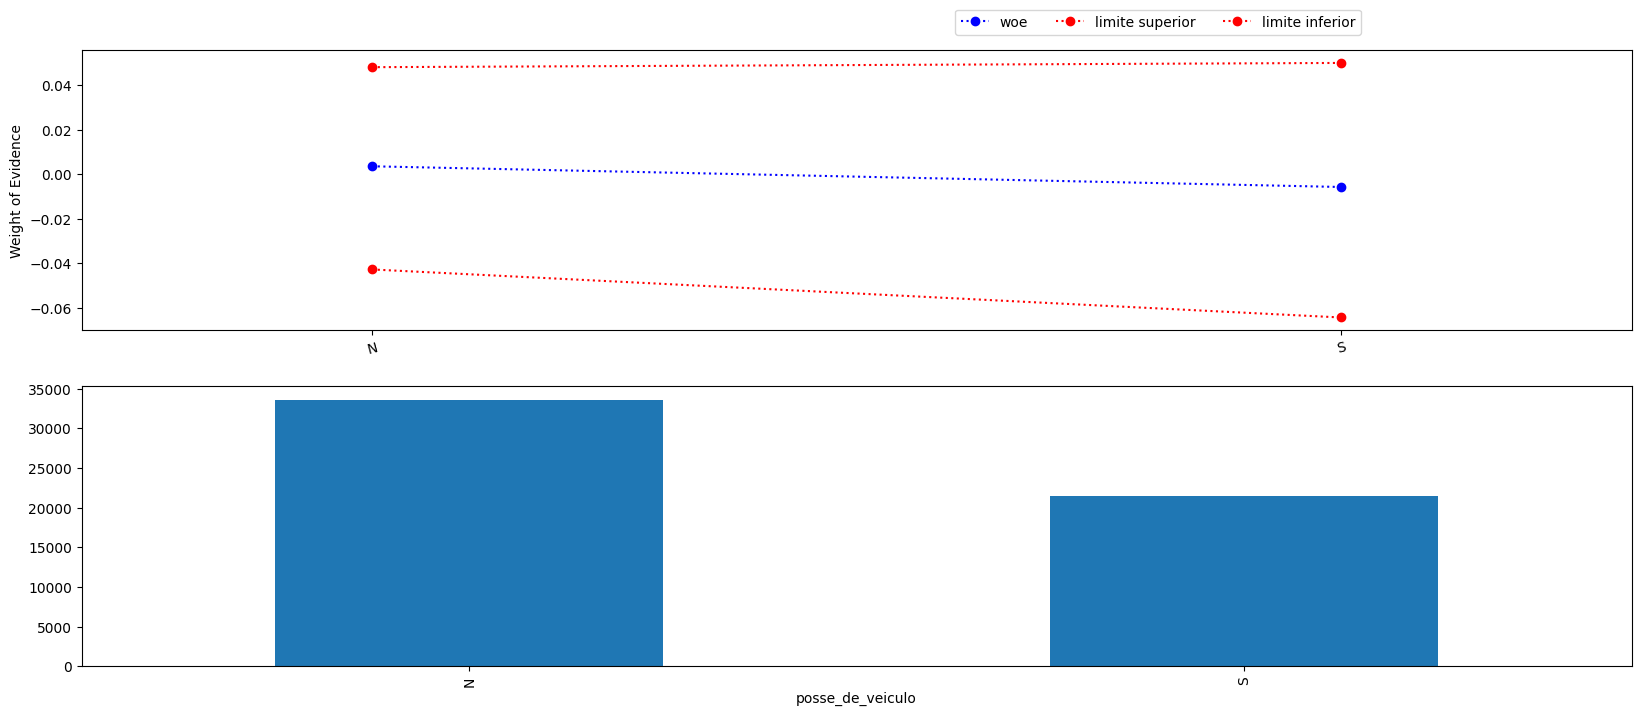

In [18]:
# Posse De Veículo
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,16560,1218,0.068512,N,17778,0.001895,0.072225,0.064798,-2.60978,-2.552998,-2.669489,0.168574,0.225357,0.108866
S,35274,2003,0.053733,S,37277,0.001168,0.056022,0.051444,-2.86850,-2.824359,-2.914452,-0.090146,-0.046004,-0.136098


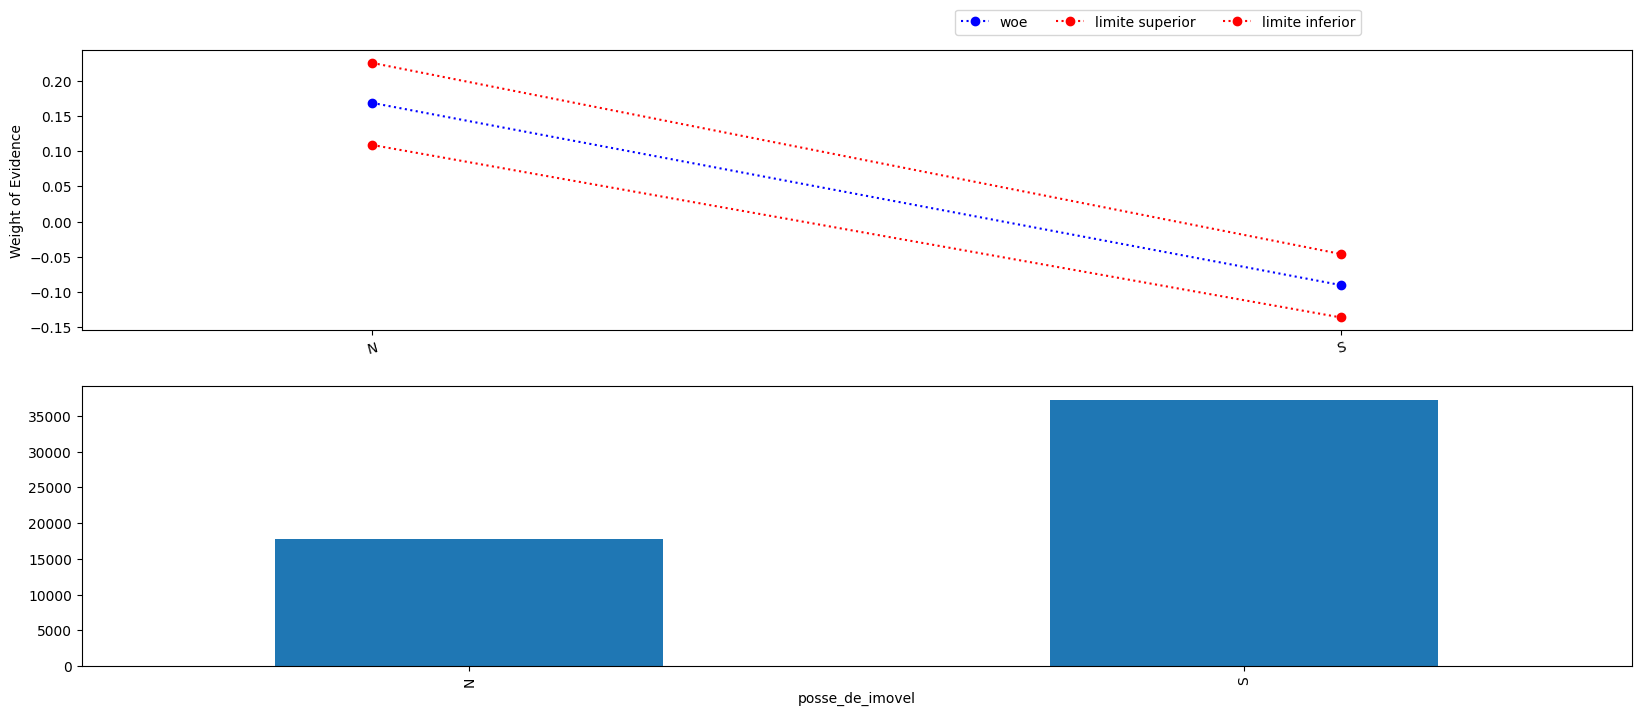

In [19]:
# Posse De Imóvel
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,26624,1733,0.061114,Assalariado,28357,0.001422,0.063902,0.058326,-2.731959,-2.684373,-2.781620,0.046395,0.093981,-0.003265
Bolsista,21,2,0.086957,Bolsista,23,0.058753,0.208804,-0.034891,-2.351375,-1.332152,NaN,0.426979,1.446202,NaN
Empresário,11863,727,0.057744,Empresário,12590,0.002079,0.061819,0.053669,-2.792253,-2.719730,-2.869750,-0.013899,0.058625,-0.091395
Pensionista,8709,583,0.062742,Pensionista,9292,0.002516,0.067673,0.057811,-2.703925,-2.622990,-2.791029,0.074429,0.155365,-0.012675
Servidor público,4617,176,0.036720,Servidor público,4793,0.002717,0.042046,0.031394,-3.267016,-3.126036,-3.429227,-0.488662,-0.347681,-0.650872


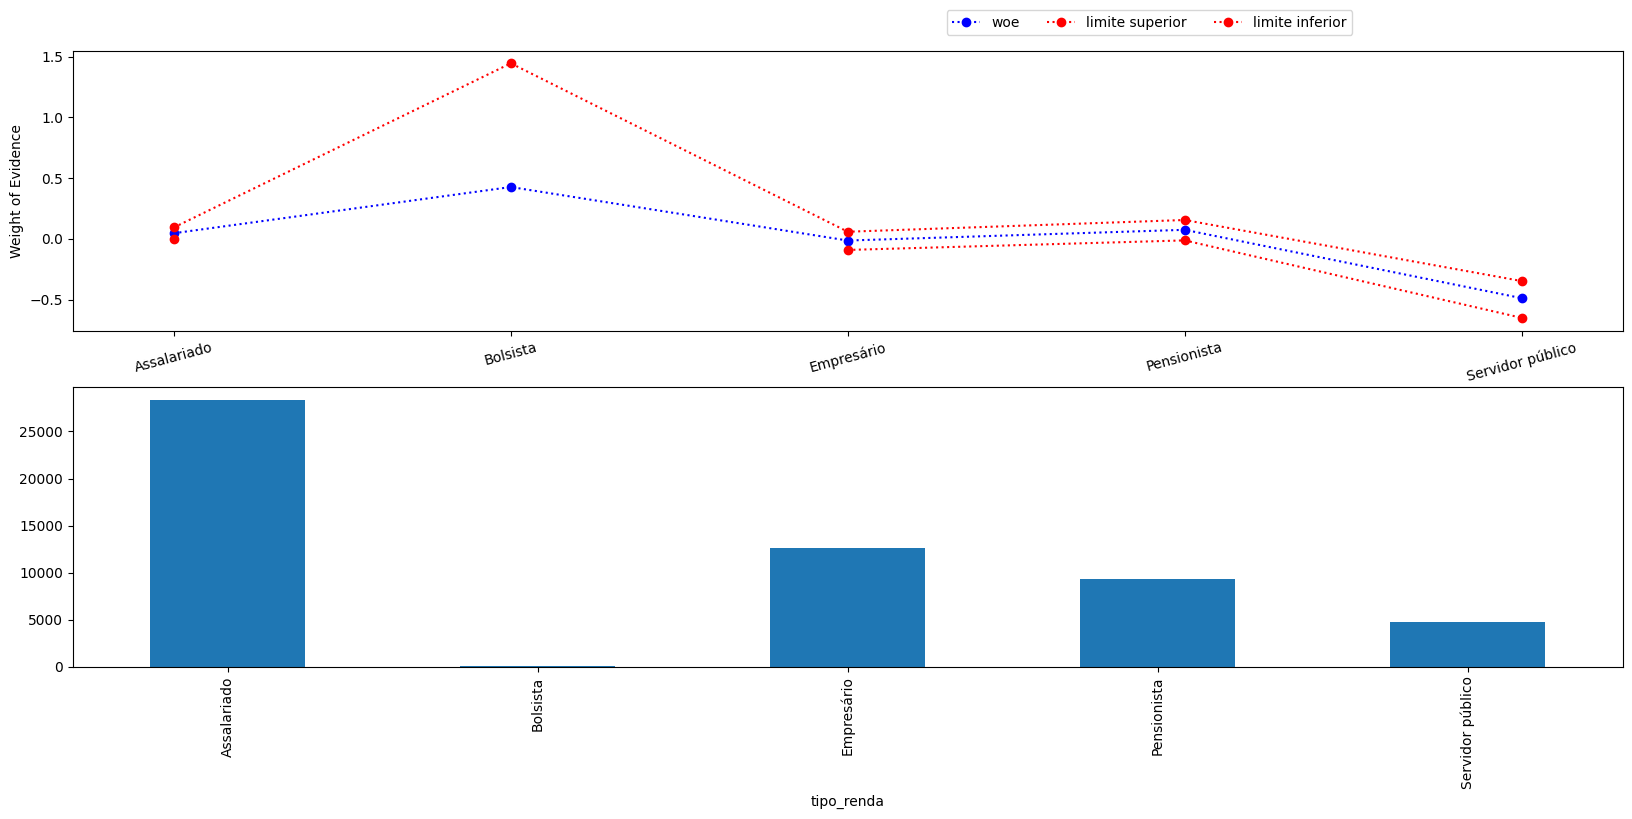

In [20]:
# Tipo Renda
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,611,51,0.077039,Fundamental,662,0.010364,0.097389,0.056689,-2.483271,-2.226576,-2.811809,0.295083,0.551778,-0.033455
Médio,34967,2262,0.060759,Médio,37229,0.001238,0.063186,0.058332,-2.738155,-2.696406,-2.781495,0.040199,0.081949,-0.003140
Pós graduação,55,1,0.017857,Pós graduação,56,0.017697,0.053323,-0.017608,-4.007333,-2.876596,NaN,-1.228979,-0.098242,NaN
Superior completo,14189,765,0.051157,Superior completo,14954,0.001802,0.054688,0.047625,-2.920346,-2.849864,-2.995592,-0.141992,-0.071510,-0.217237
Superior incompleto,2012,142,0.065924,Superior incompleto,2154,0.005347,0.076409,0.055439,-2.651057,-2.492166,-2.835446,0.127297,0.286188,-0.057091


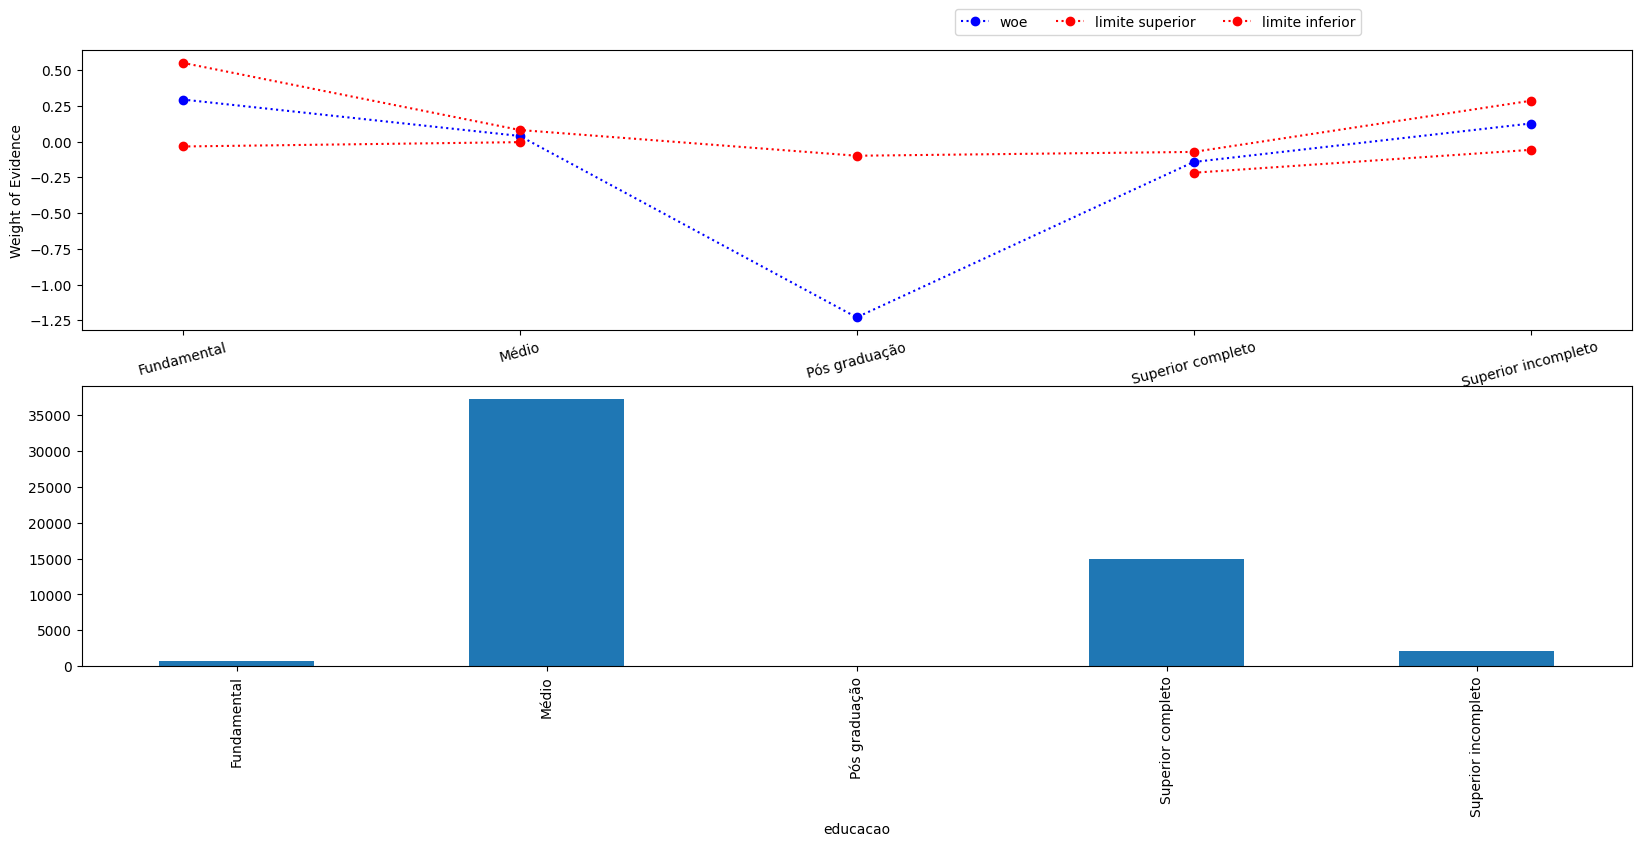

In [21]:
# Educação
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,36424,2229,0.057667,Casado,38653,0.001186,0.059991,0.055343,-2.793675,-2.751696,-2.837273,-0.015320,0.026658,-0.058919
Separado,3042,193,0.059660,Separado,3235,0.004164,0.067825,0.051495,-2.757580,-2.620590,-2.913403,0.020774,0.157765,-0.135049
Solteiro,6174,405,0.061560,Solteiro,6579,0.002963,0.067368,0.055751,-2.724215,-2.627833,-2.829503,0.054139,0.150521,-0.051149
União,4006,261,0.061167,União,4267,0.003669,0.068359,0.053975,-2.731028,-2.612169,-2.863750,0.047326,0.166185,-0.085396
Viúvo,2188,133,0.057303,Viúvo,2321,0.004824,0.066763,0.047842,-2.800394,-2.637505,-2.990817,-0.022040,0.140850,-0.212463


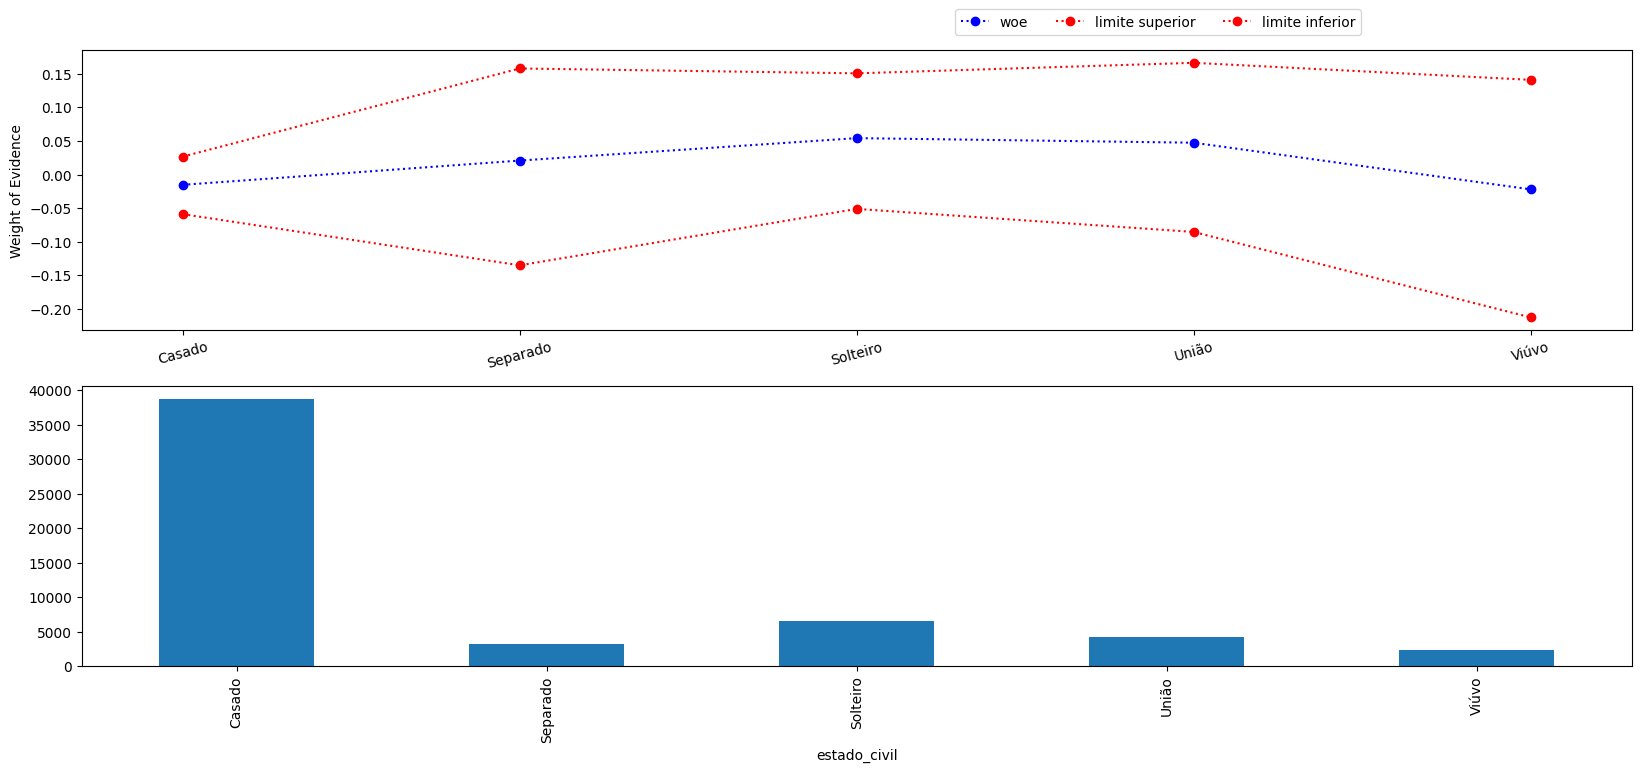

In [22]:
# Estado Civil
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,36424,2229,0.057667,Casado,38653,0.001186,0.059991,0.055343,-2.793675,-2.751696,-2.837273,-0.015320,0.026658,-0.058919
Separado,3042,193,0.059660,Separado,3235,0.004164,0.067825,0.051495,-2.757580,-2.620590,-2.913403,0.020774,0.157765,-0.135049
Solteiro,6174,405,0.061560,Solteiro,6579,0.002963,0.067368,0.055751,-2.724215,-2.627833,-2.829503,0.054139,0.150521,-0.051149
União,4006,261,0.061167,União,4267,0.003669,0.068359,0.053975,-2.731028,-2.612169,-2.863750,0.047326,0.166185,-0.085396
Viúvo,2188,133,0.057303,Viúvo,2321,0.004824,0.066763,0.047842,-2.800394,-2.637505,-2.990817,-0.022040,0.140850,-0.212463


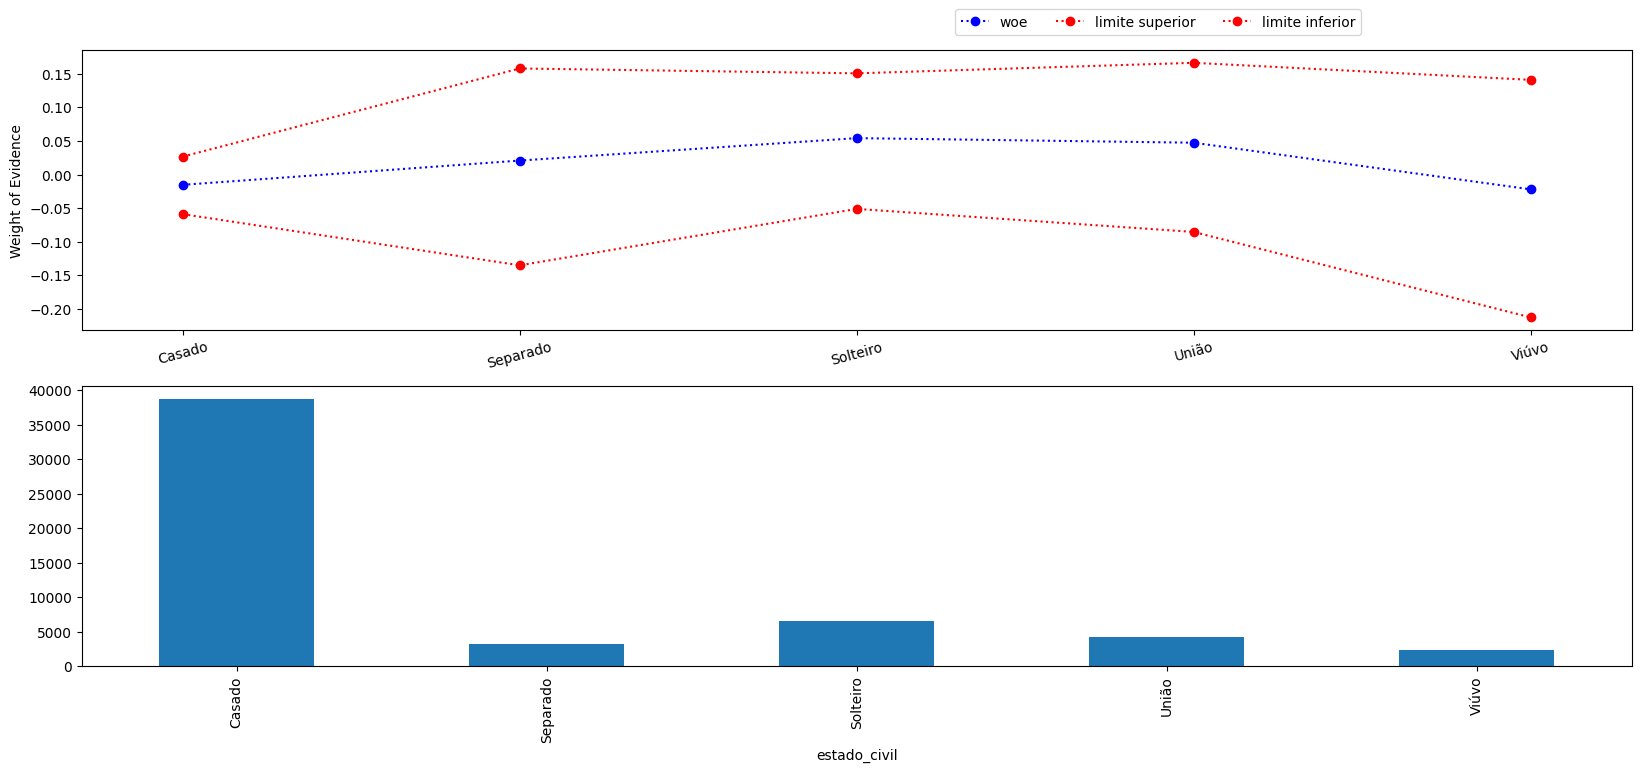

In [ ]:
# Tipo Residência
c += 1
biv_discreta(var=categorias[c], df=df_train)

#### Base Validação

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,11572,1829,0.136482,F,13401,0.002966,0.142295,0.130669,-1.844819,-1.796356,-1.895053,0.022795,0.071259,-0.027438
M,5704,840,0.128362,M,6544,0.004135,0.136468,0.120256,-1.915521,-1.844944,-1.990007,-0.047907,0.022670,-0.122393


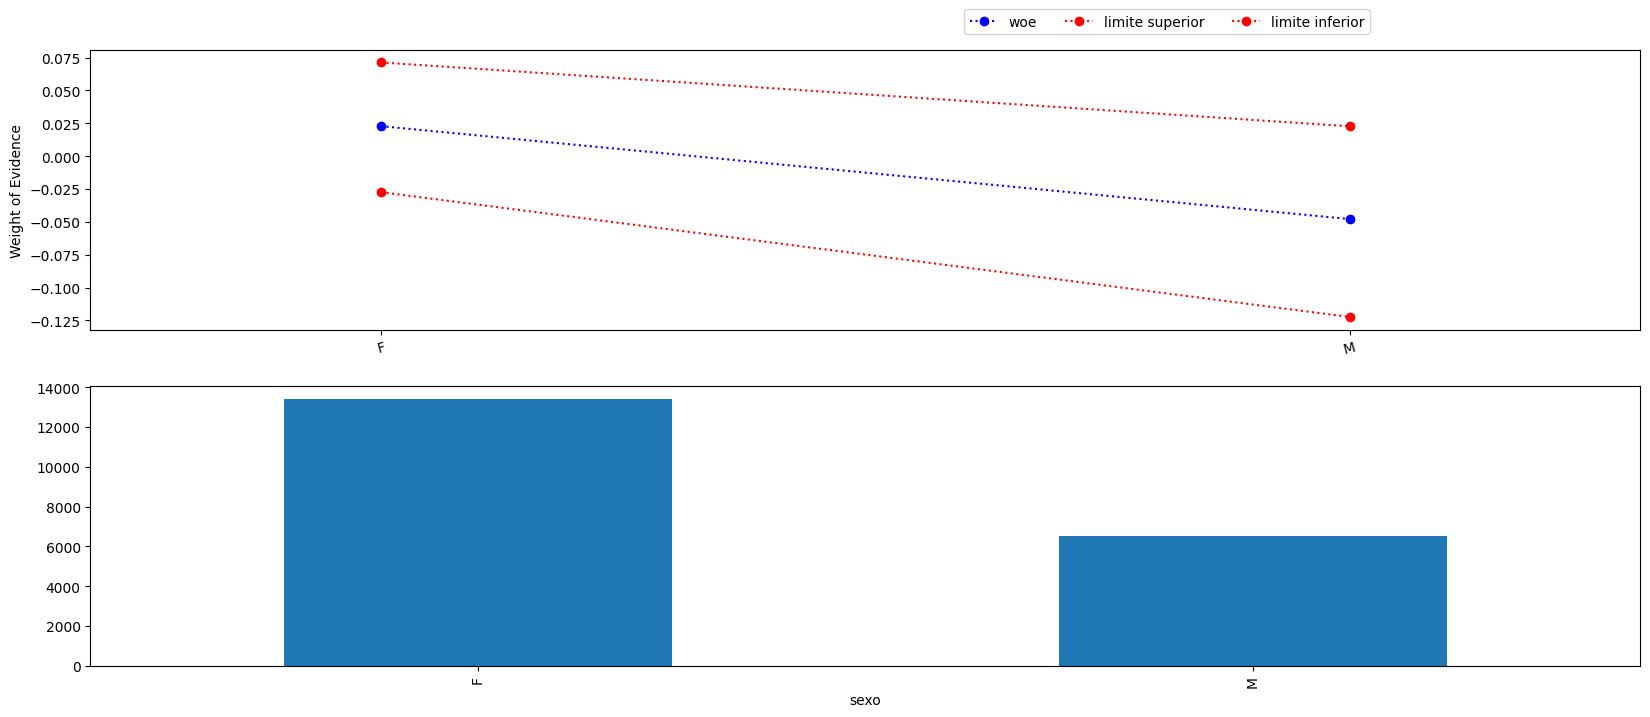

In [23]:
c = 0
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,10569,1660,0.135743,N,12229,0.003097,0.141814,0.129672,-1.851108,-1.800304,-1.903865,0.016507,0.067311,-0.036250
S,6707,1009,0.130767,S,7716,0.003838,0.138291,0.123243,-1.894192,-1.829557,-1.962068,-0.026578,0.038057,-0.094453


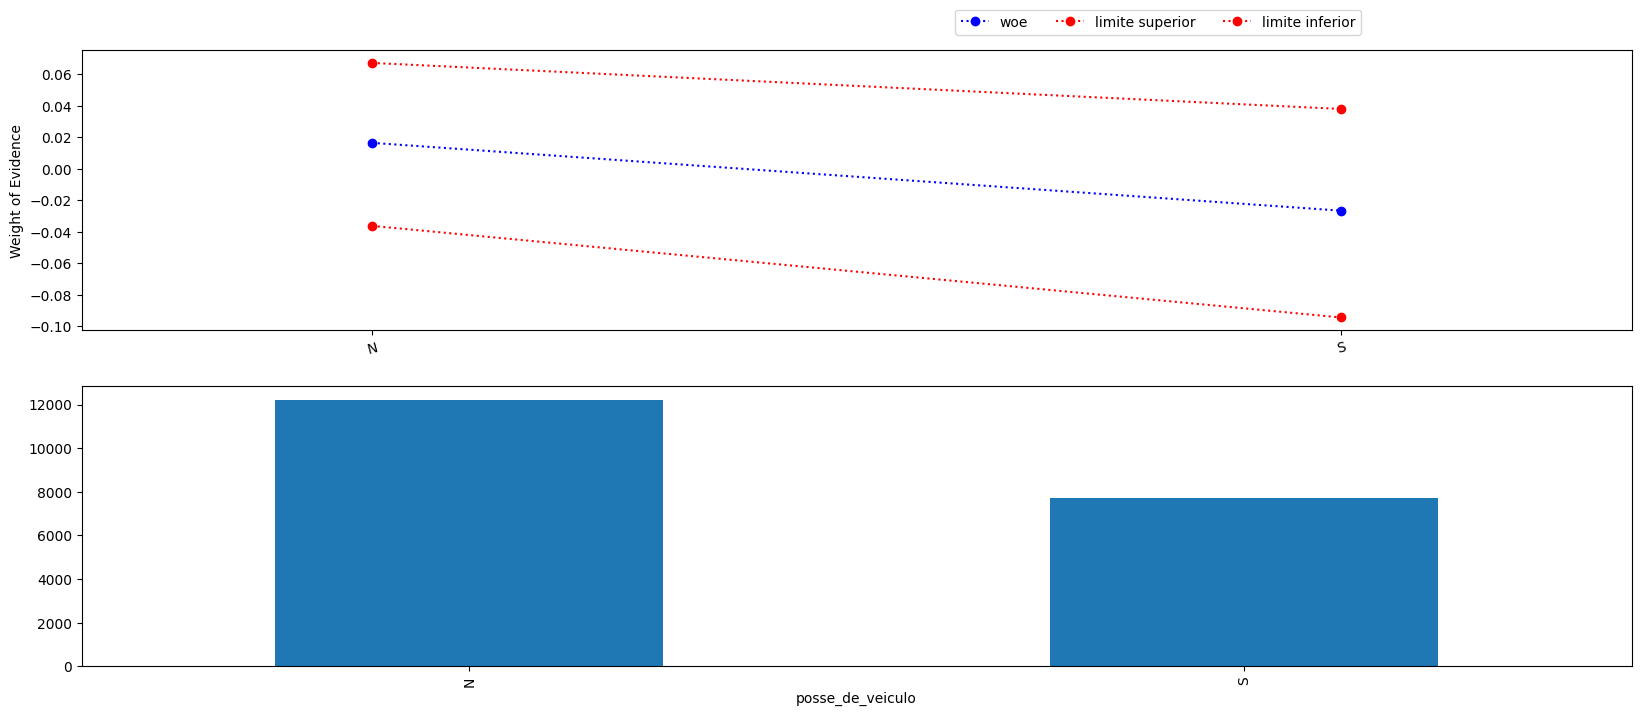

In [24]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,5487,1021,0.156884,N,6508,0.004508,0.165722,0.148046,-1.681599,-1.616259,-1.750008,0.186015,0.251356,0.117606
S,11789,1648,0.122646,S,13437,0.002830,0.128193,0.117100,-1.967604,-1.917028,-2.020188,-0.099990,-0.049414,-0.152574


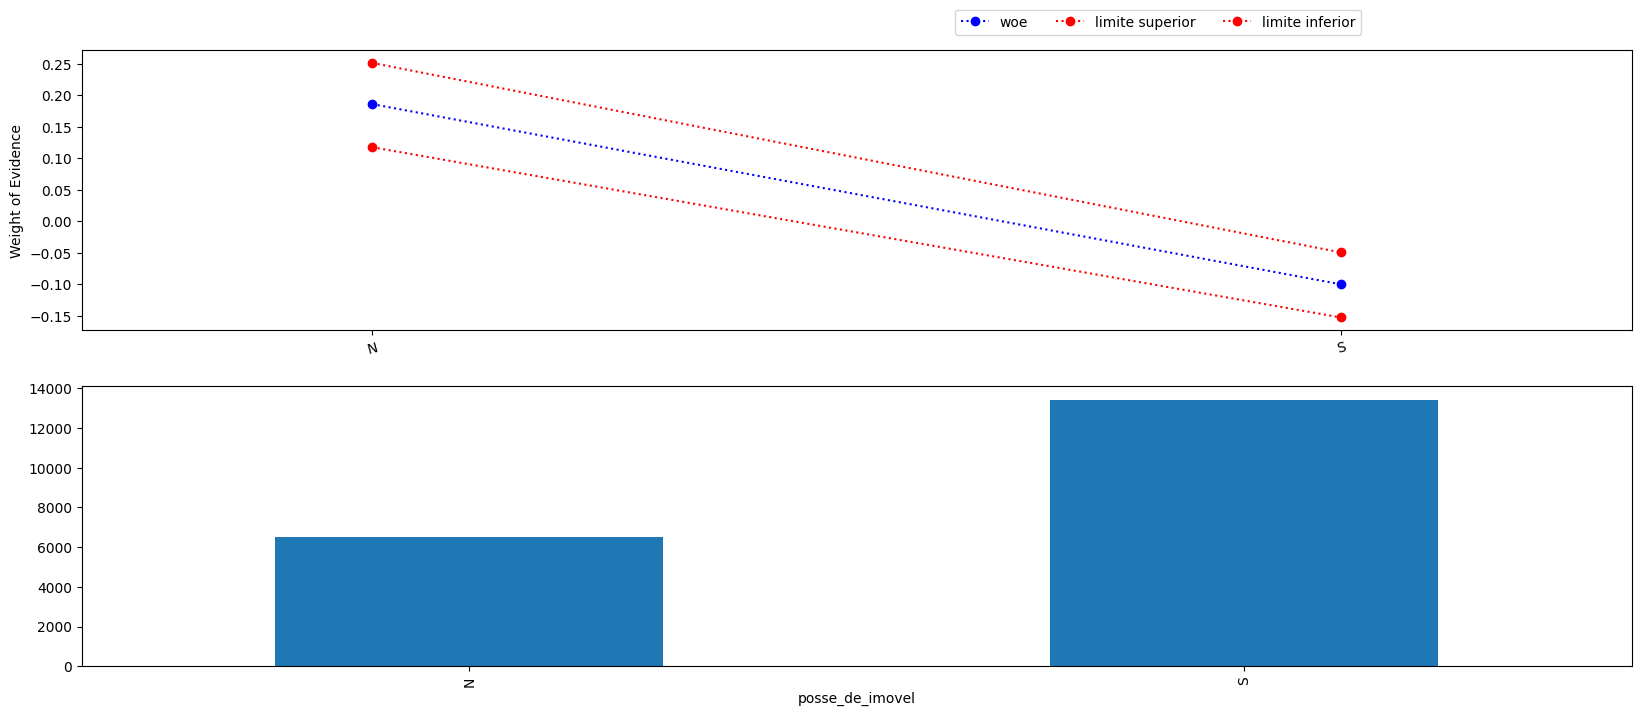

In [25]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,8926,1436,0.138583,Assalariado,10362,0.003394,0.145237,0.131930,-1.827107,-1.772460,-1.884001,0.040507,0.095154,-0.016387
Bolsista,10,1,0.090909,Bolsista,11,0.086678,0.284041,-0.102222,-2.302585,-0.924506,NaN,-0.434971,0.943108,NaN
Empresário,3974,581,0.127552,Empresário,4555,0.004943,0.137242,0.117862,-1.922778,-1.838386,-2.012835,-0.055163,0.029229,-0.145220
Pensionista,2848,478,0.143716,Pensionista,3326,0.006083,0.155643,0.131790,-1.784762,-1.691014,-1.885225,0.082853,0.176600,-0.017611
Servidor público,1518,173,0.102306,Servidor público,1691,0.007370,0.116761,0.087852,-2.171857,-2.023468,-2.340151,-0.304243,-0.155854,-0.472536


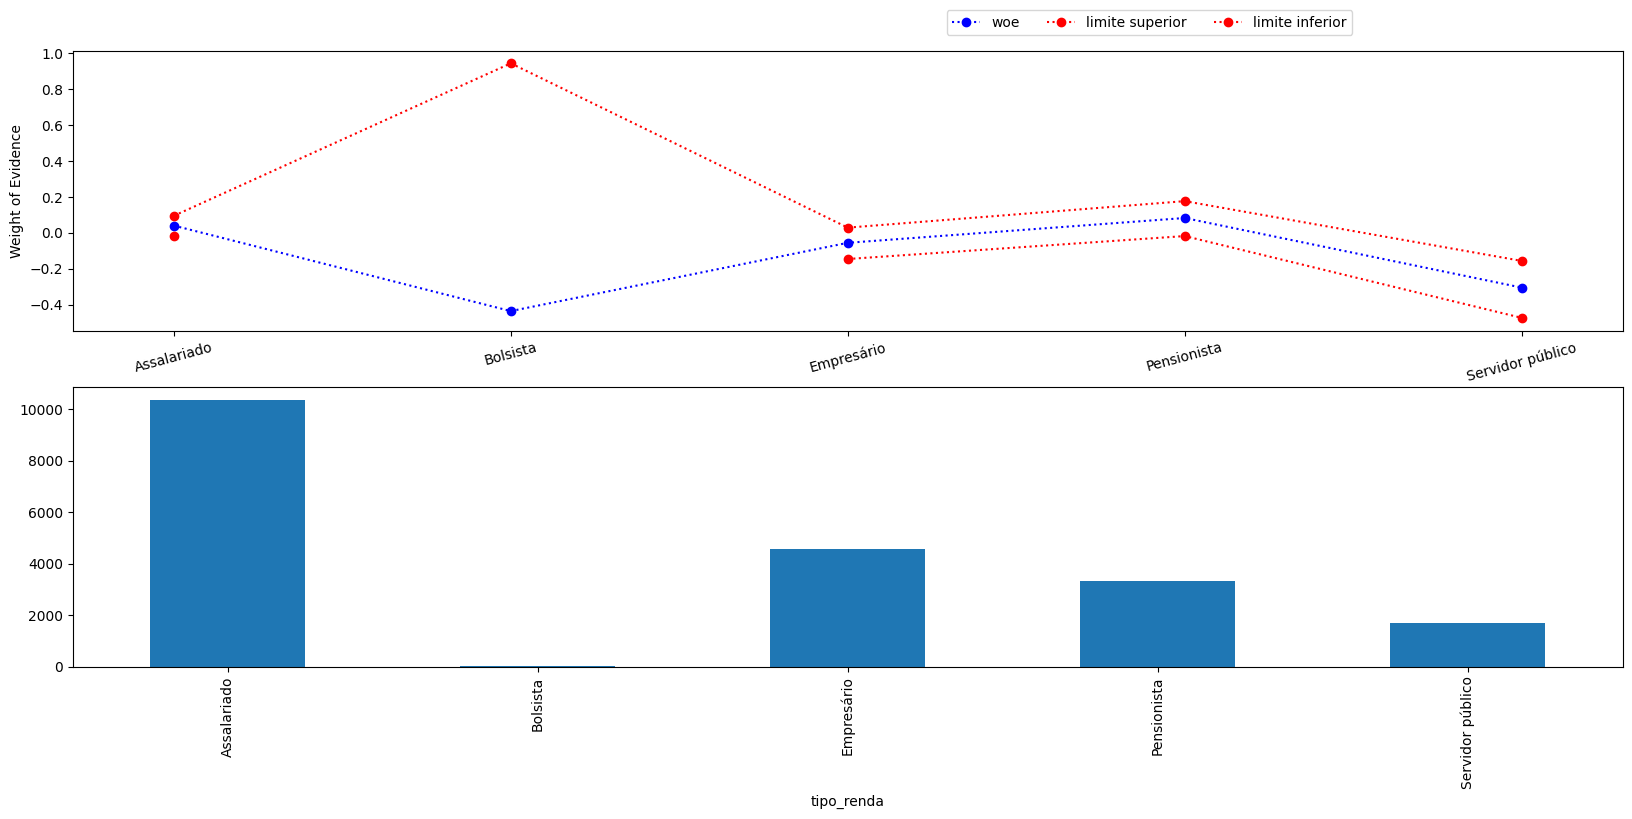

In [26]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,189,30,0.136986,Fundamental,219,0.023234,0.182778,0.091194,-1.840550,-1.497635,-2.299141,0.027065,0.369979,-0.431527
Médio,11737,1830,0.134886,Médio,13567,0.002933,0.140635,0.129137,-1.858430,-1.810028,-1.908607,0.009184,0.057587,-0.040992
Pós graduação,24,5,0.172414,Pós graduação,29,0.070145,0.316098,0.028729,-1.568616,-0.771761,-3.520688,0.298998,1.095853,-1.653073
Superior completo,4656,698,0.130370,Superior completo,5354,0.004602,0.139391,0.121349,-1.897693,-1.820357,-1.979720,-0.030079,0.047257,-0.112106
Superior incompleto,670,106,0.136598,Superior incompleto,776,0.012328,0.160798,0.112397,-1.843839,-1.652299,-2.066483,0.023776,0.215315,-0.198869


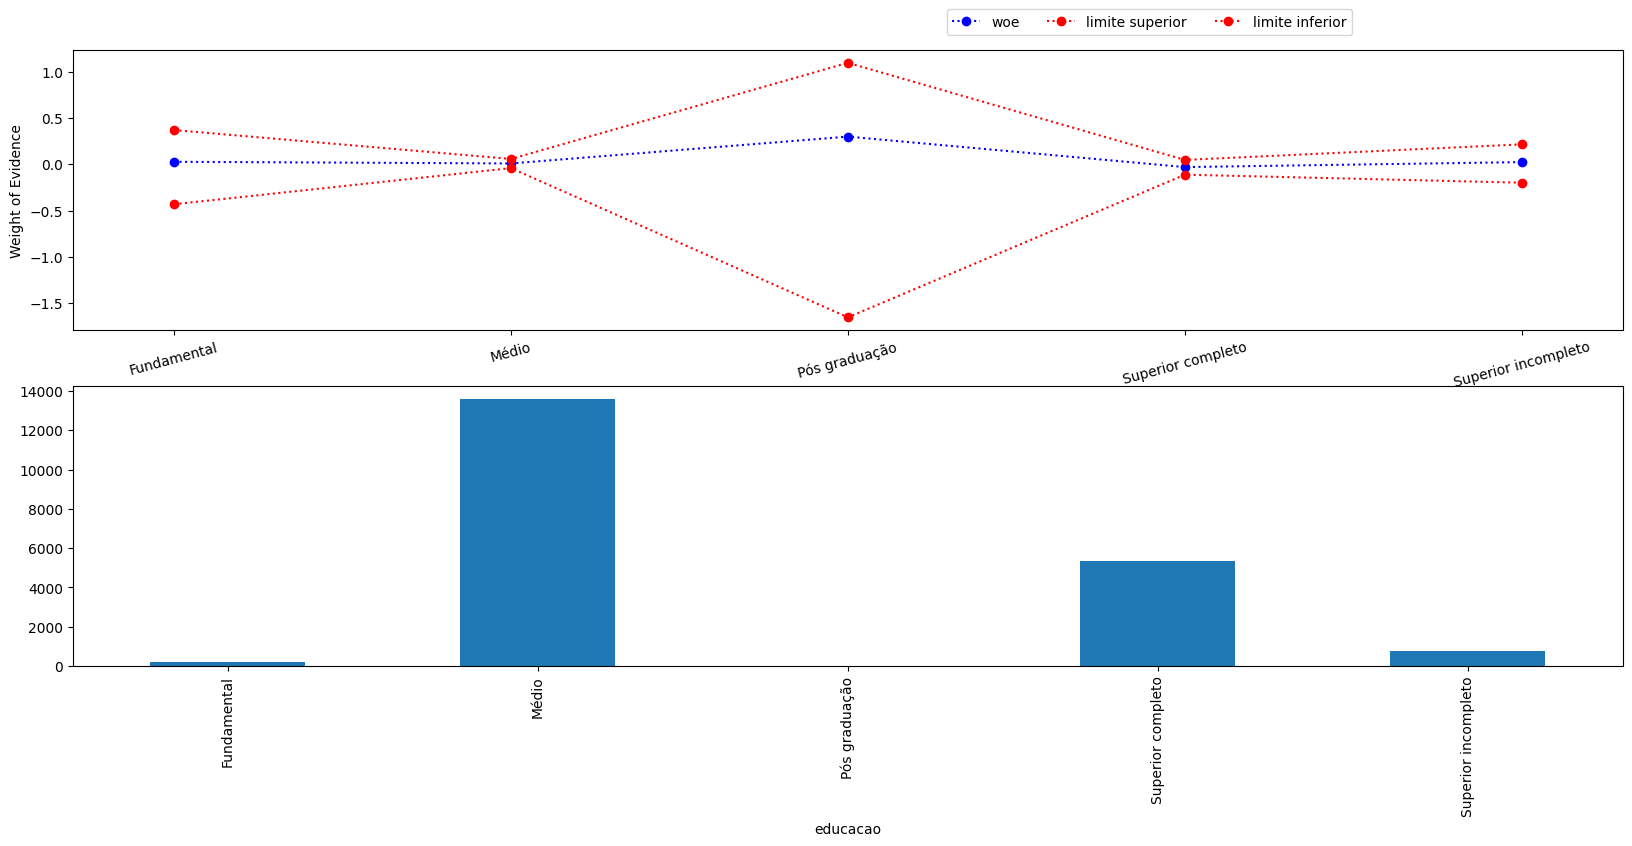

In [27]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,12170,1873,0.133376,Casado,14043,0.002869,0.139000,0.127753,-1.871432,-1.823624,-1.920978,-0.003818,0.043990,-0.053364
Separado,948,172,0.153571,Separado,1120,0.010773,0.174709,0.132434,-1.706860,-1.552613,-1.879610,0.160754,0.315002,-0.011996
Solteiro,2150,304,0.123879,Solteiro,2454,0.006650,0.136920,0.110839,-1.956195,-1.841108,-2.082205,-0.088581,0.026506,-0.214590
União,1310,226,0.147135,União,1536,0.009039,0.164865,0.129406,-1.757247,-1.622468,-1.906221,0.110367,0.245147,-0.038606
Viúvo,698,94,0.118687,Viúvo,792,0.011492,0.141246,0.096128,-2.004924,-1.804982,-2.241007,-0.137310,0.062633,-0.373393


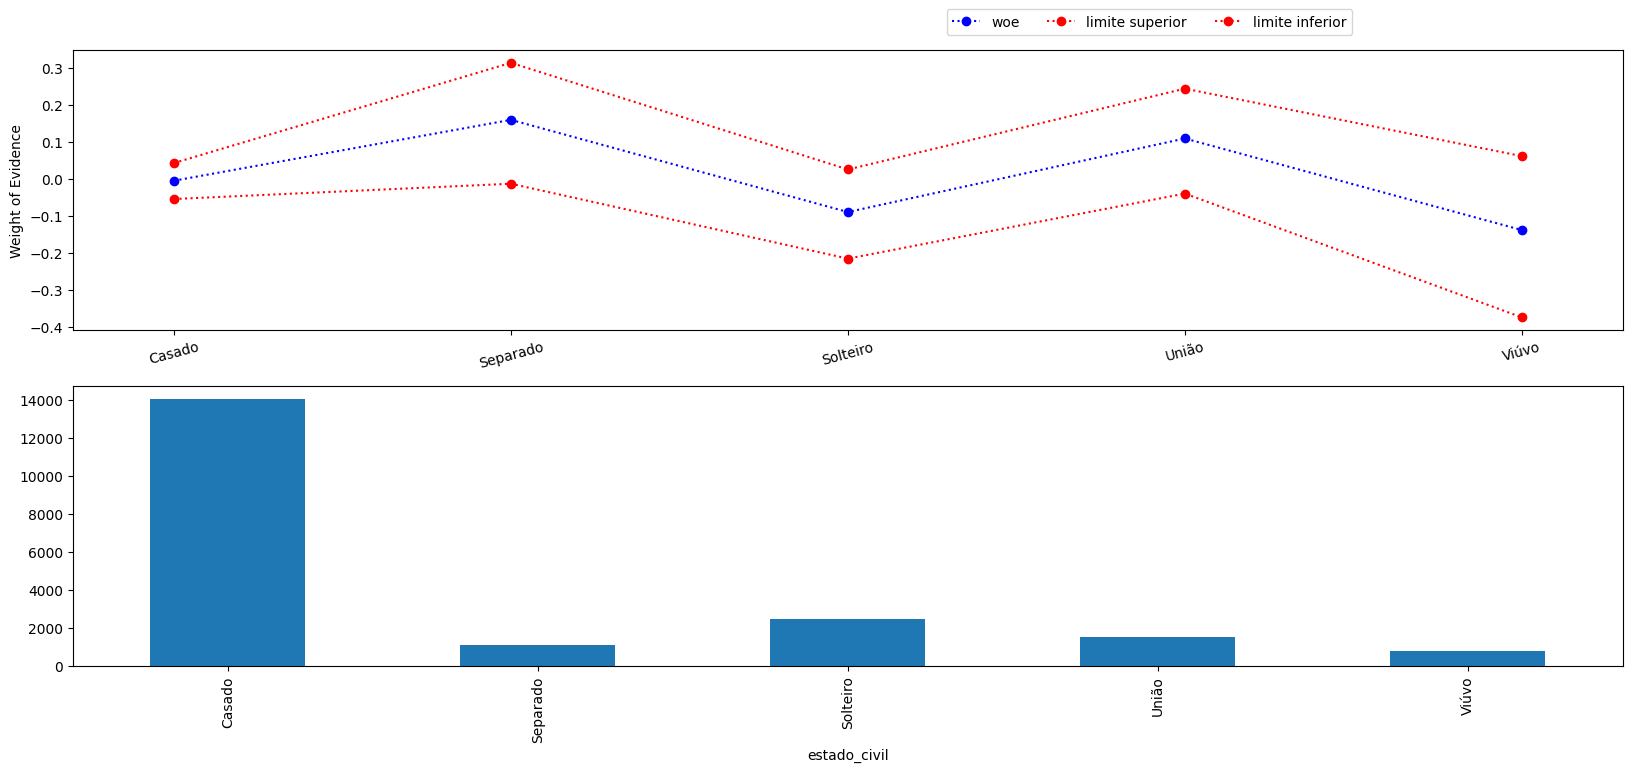

In [28]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,210,29,0.121339,Aluguel,239,0.021121,0.162947,0.079731,-1.979812,-1.636465,-2.446005,-0.112197,0.231149,-0.578391
Casa,15639,2368,0.131504,Casa,18007,0.002518,0.136441,0.126568,-1.887722,-1.845171,-1.931650,-0.020108,0.022443,-0.064036
Com os pais,728,151,0.171786,Com os pais,879,0.012722,0.196756,0.146816,-1.573021,-1.406694,-1.759794,0.294593,0.460921,0.107820
Comunitário,73,9,0.109756,Comunitário,82,0.034519,0.178439,0.041074,-2.093235,-1.526962,-3.150451,-0.225620,0.340653,-1.282836
Estúdio,130,16,0.109589,Estúdio,146,0.025852,0.160685,0.058493,-2.094946,-1.653137,-2.778581,-0.227331,0.214478,-0.910967
Governamental,496,96,0.162162,Governamental,592,0.015149,0.191915,0.132409,-1.642228,-1.437613,-1.879824,0.225387,0.430001,-0.012210


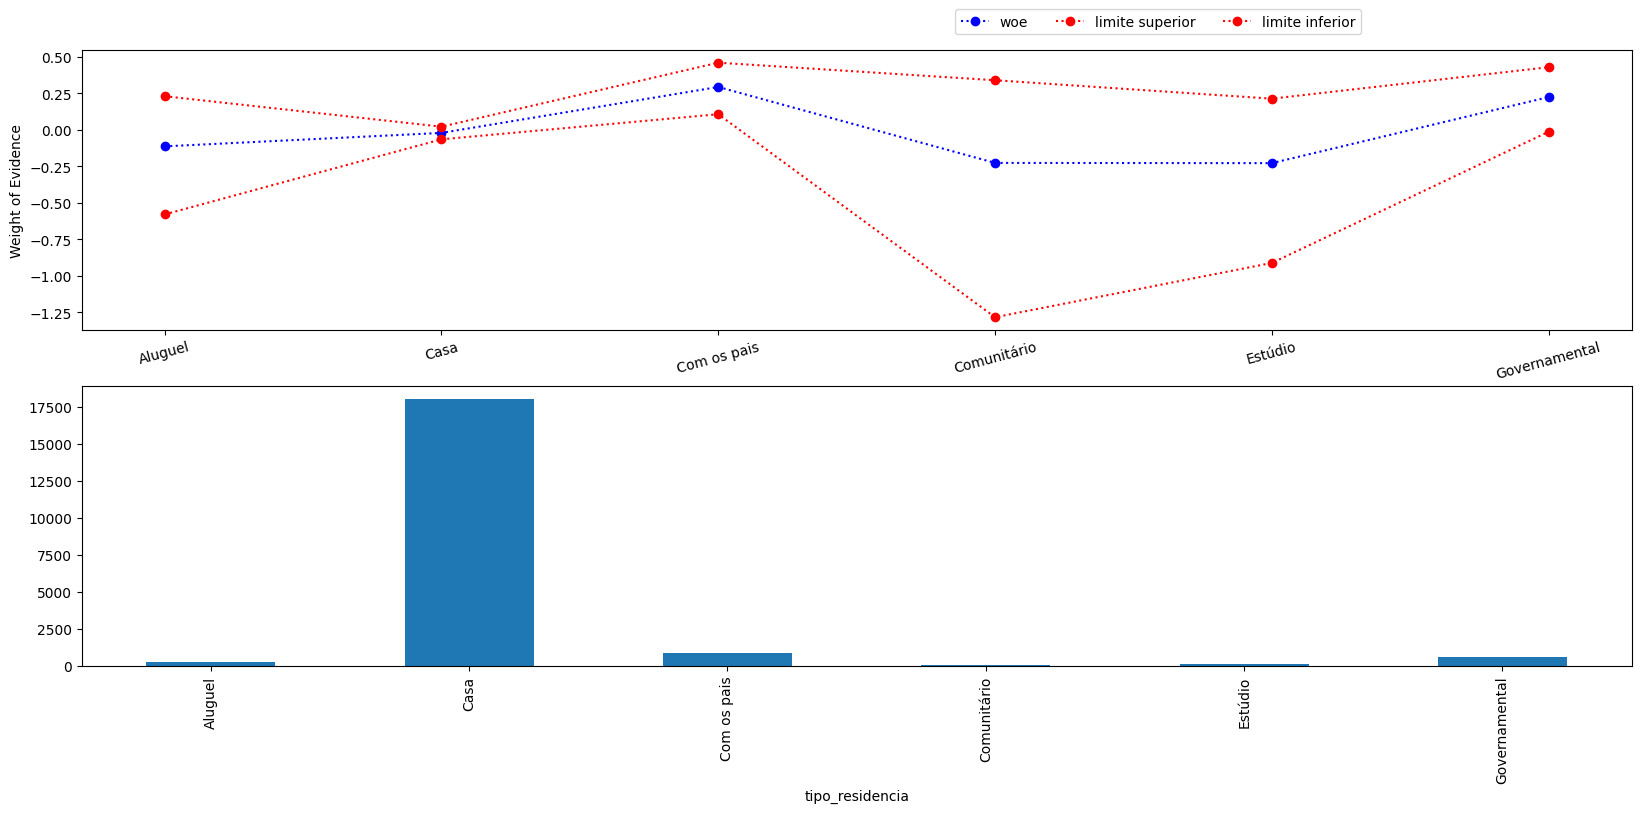

In [29]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

In [30]:
# Função de gráfico e calculos WOE
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, _ = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    _, ax = plt.subplots(2,1, figsize=(20, 8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [31]:
continuas = df_train.select_dtypes(['int64','float64']).dtypes.index
continuas

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'renda_log'],
      dtype='object')

#### Base Teste

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


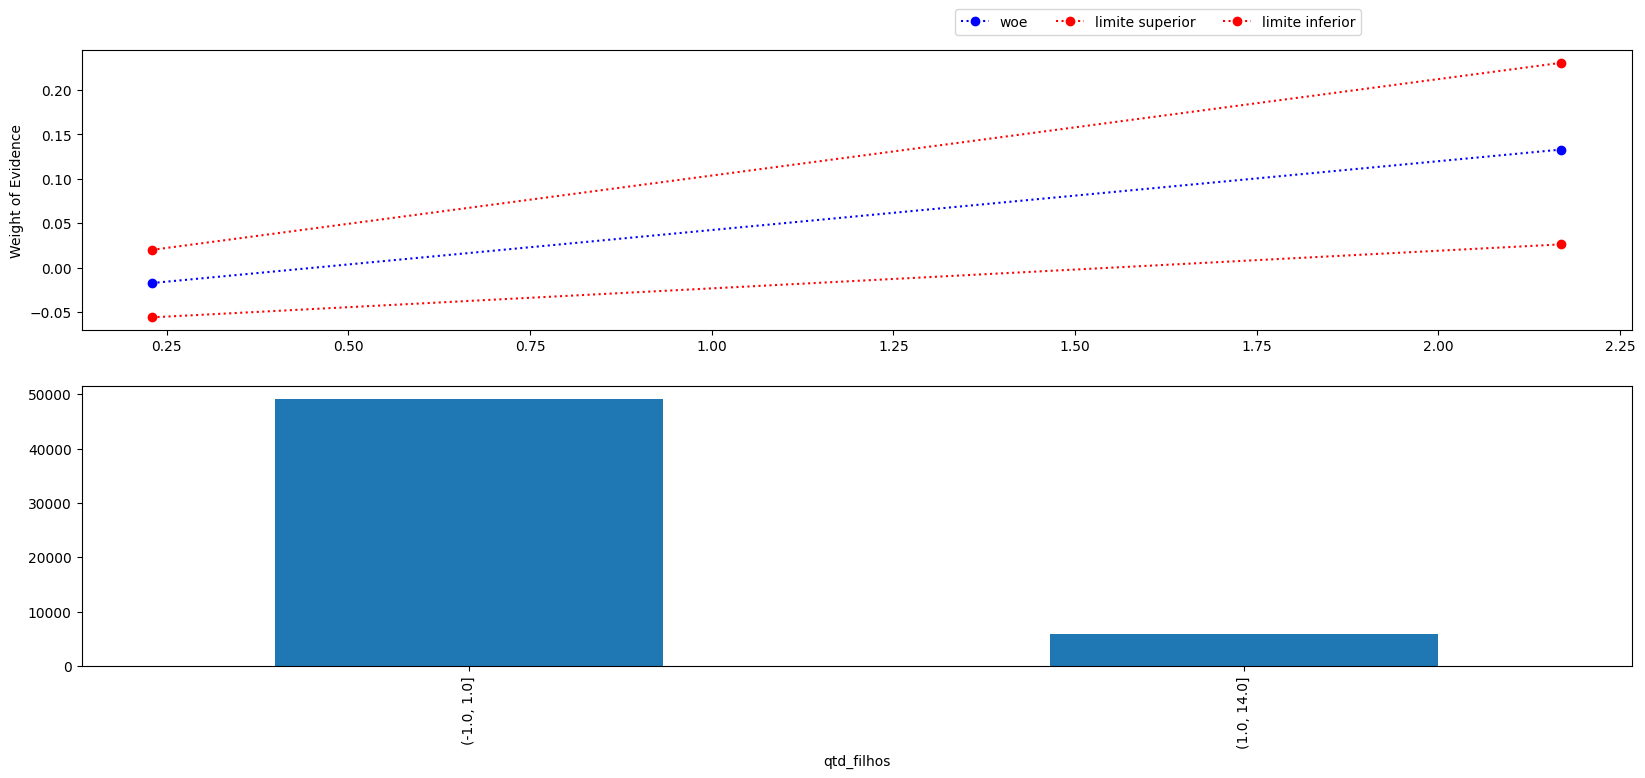

In [32]:
c = 0
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


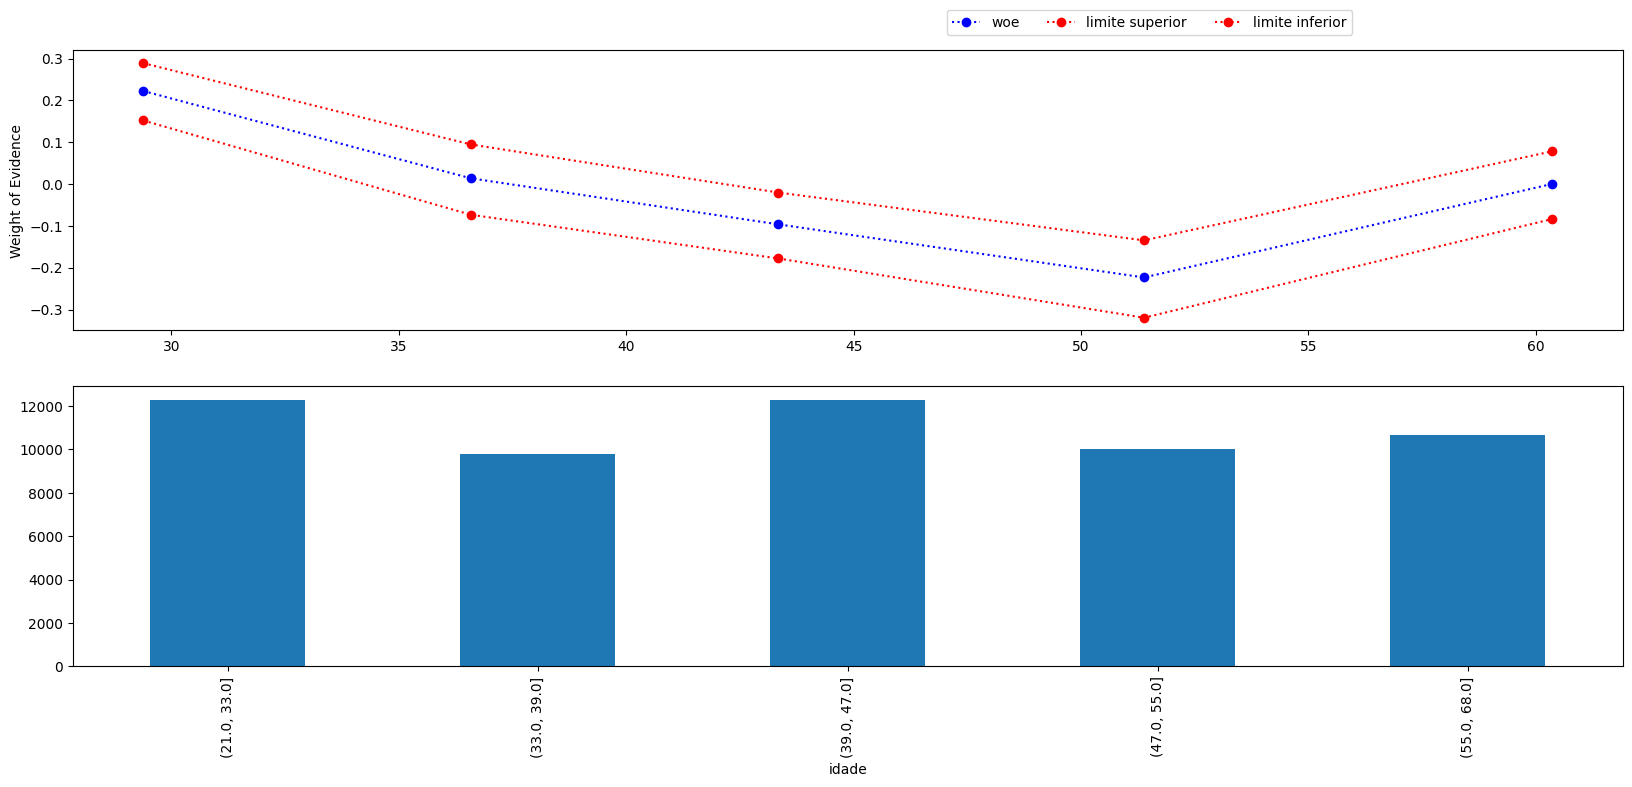

In [33]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


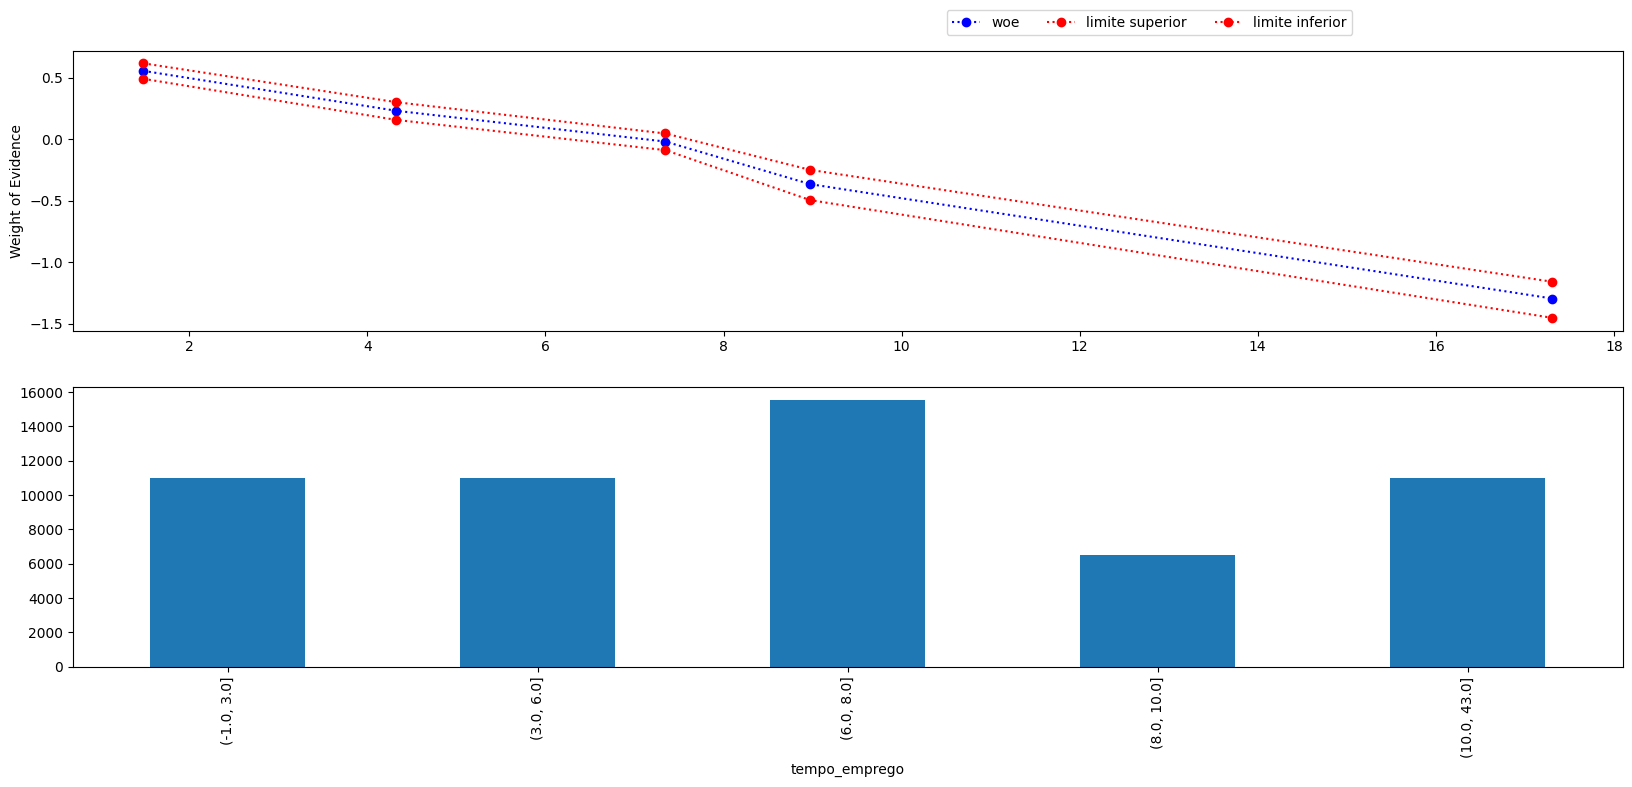

In [34]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


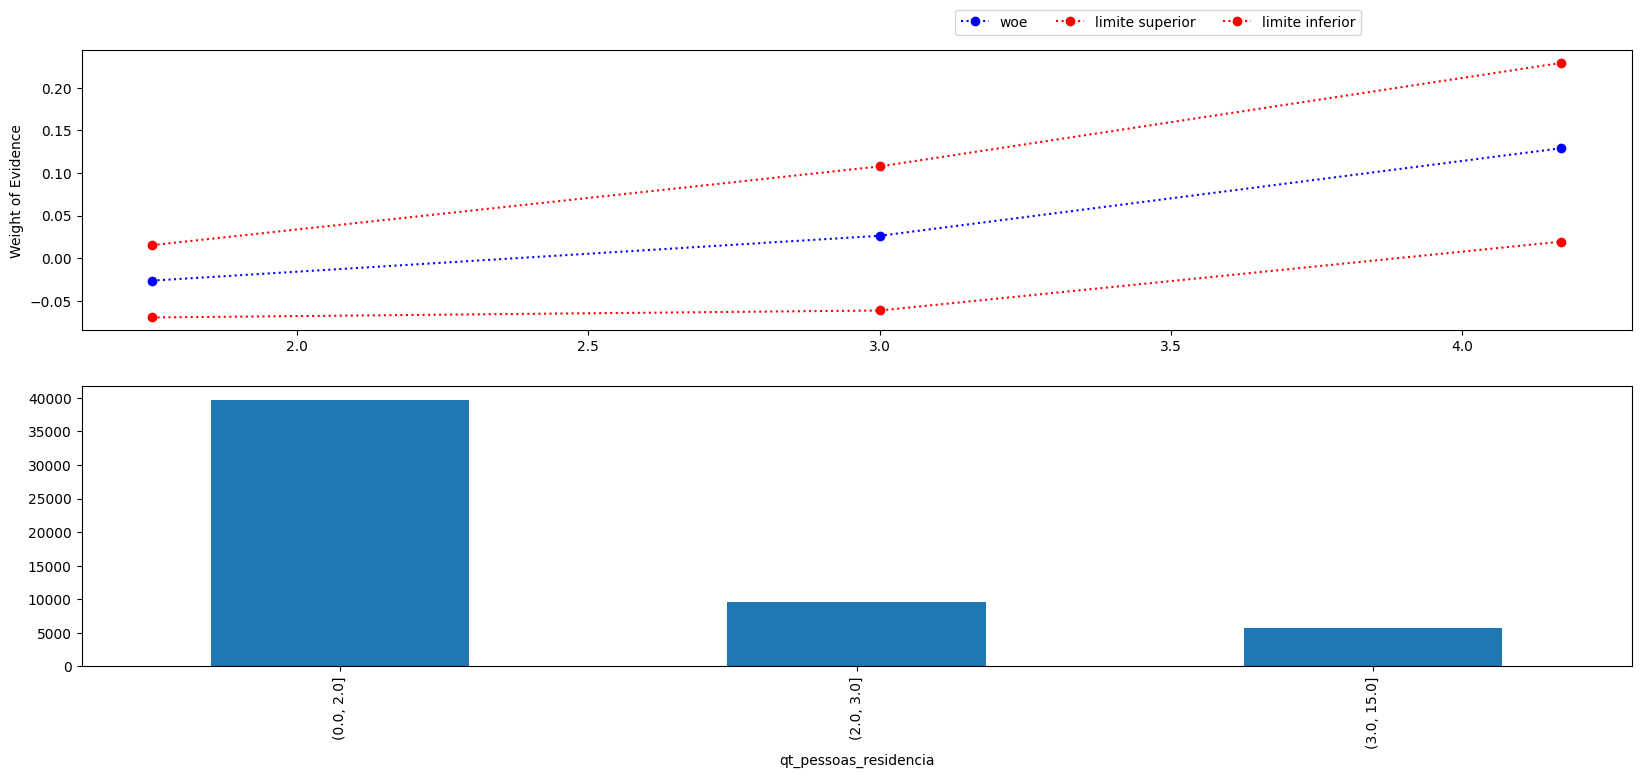

In [35]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


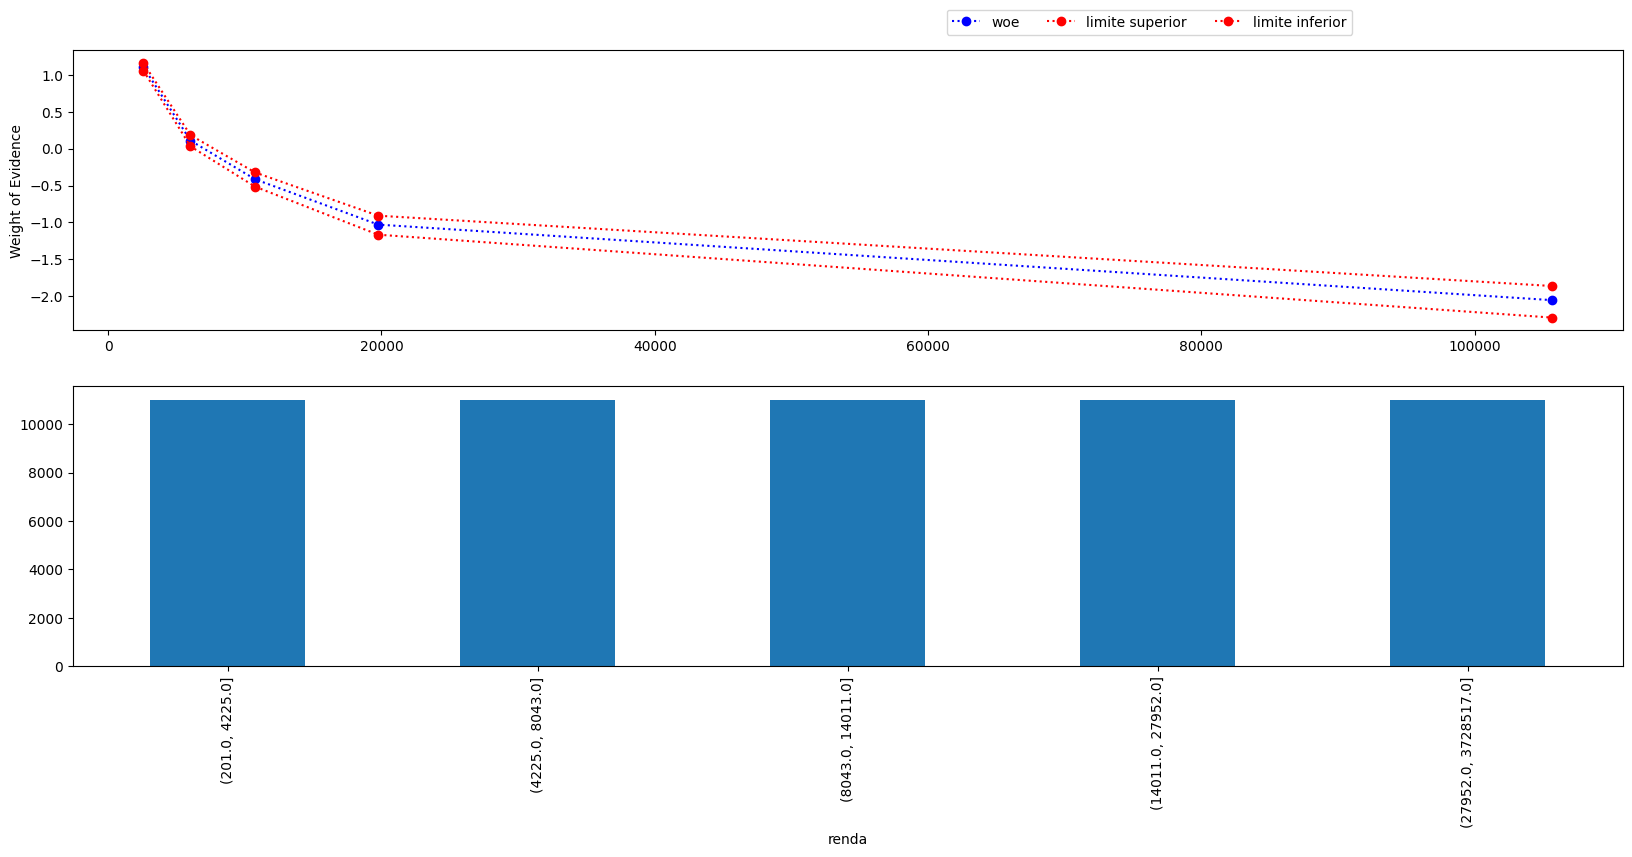

In [36]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


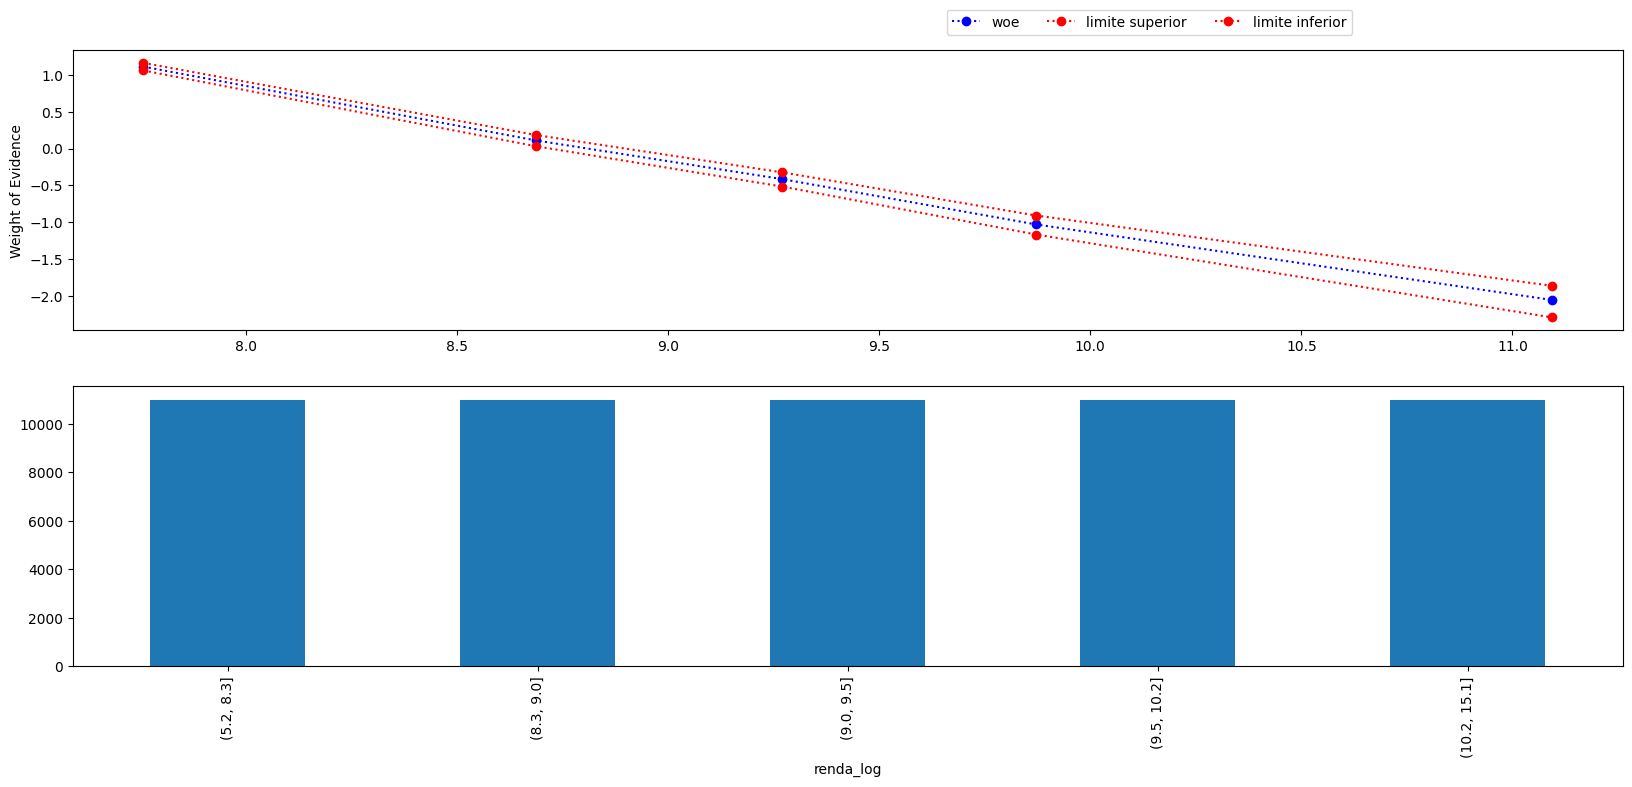

In [37]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

#### Base Validação

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


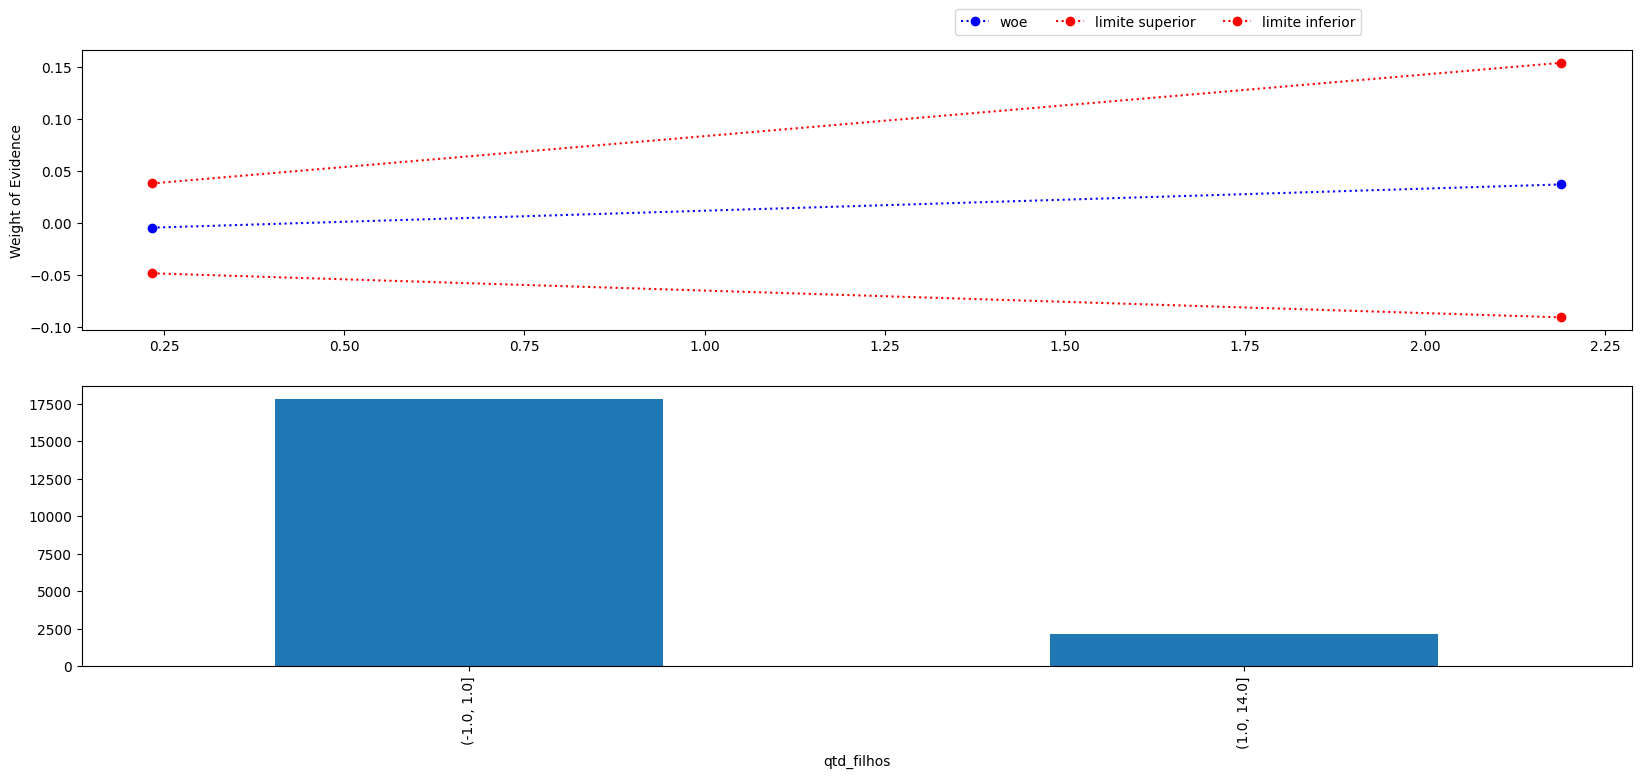

In [38]:
c = 0
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


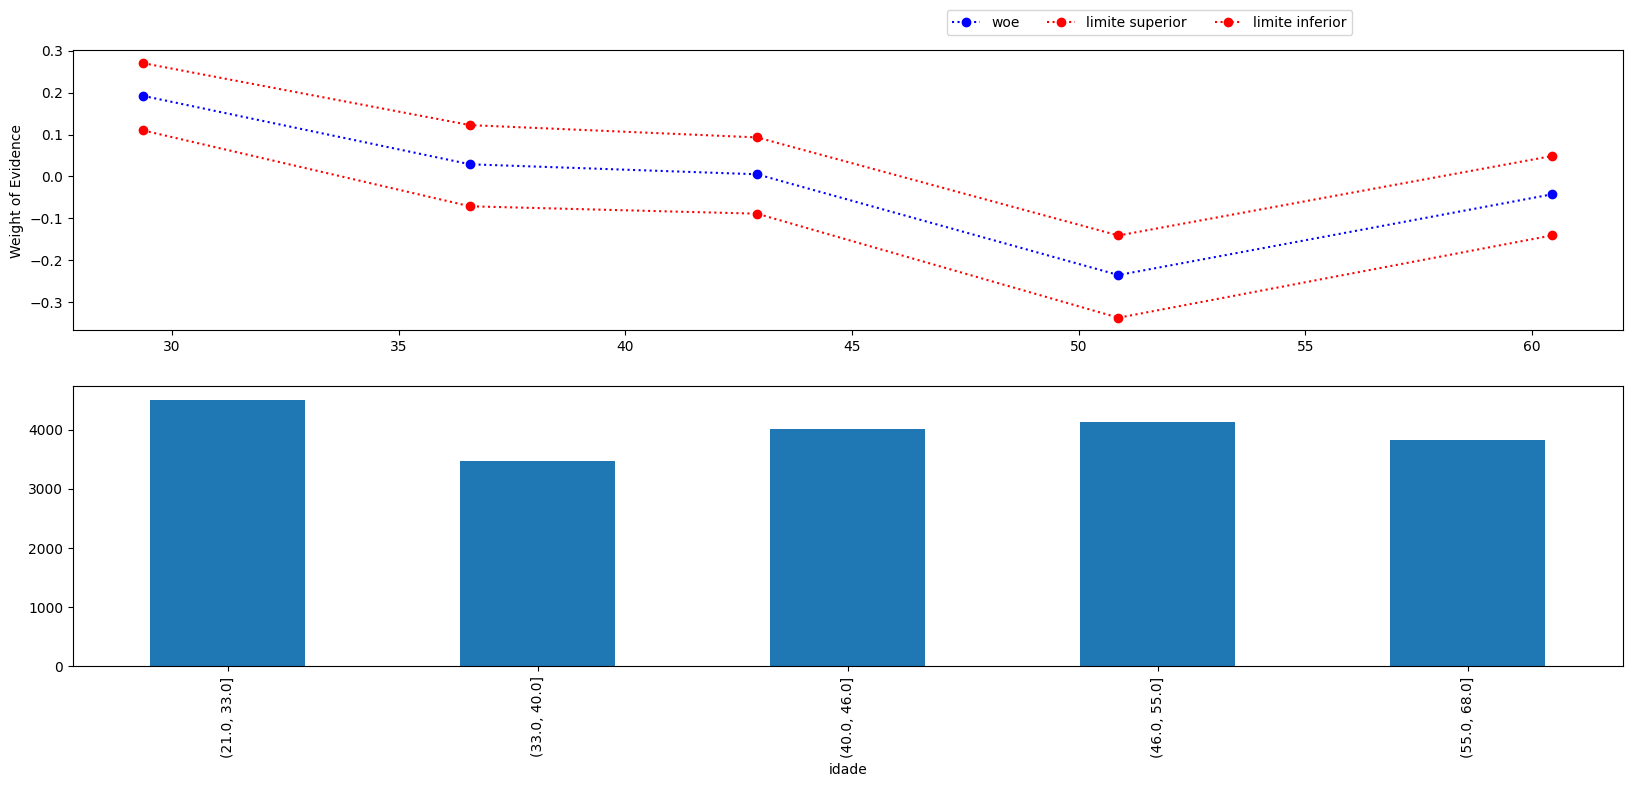

In [39]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


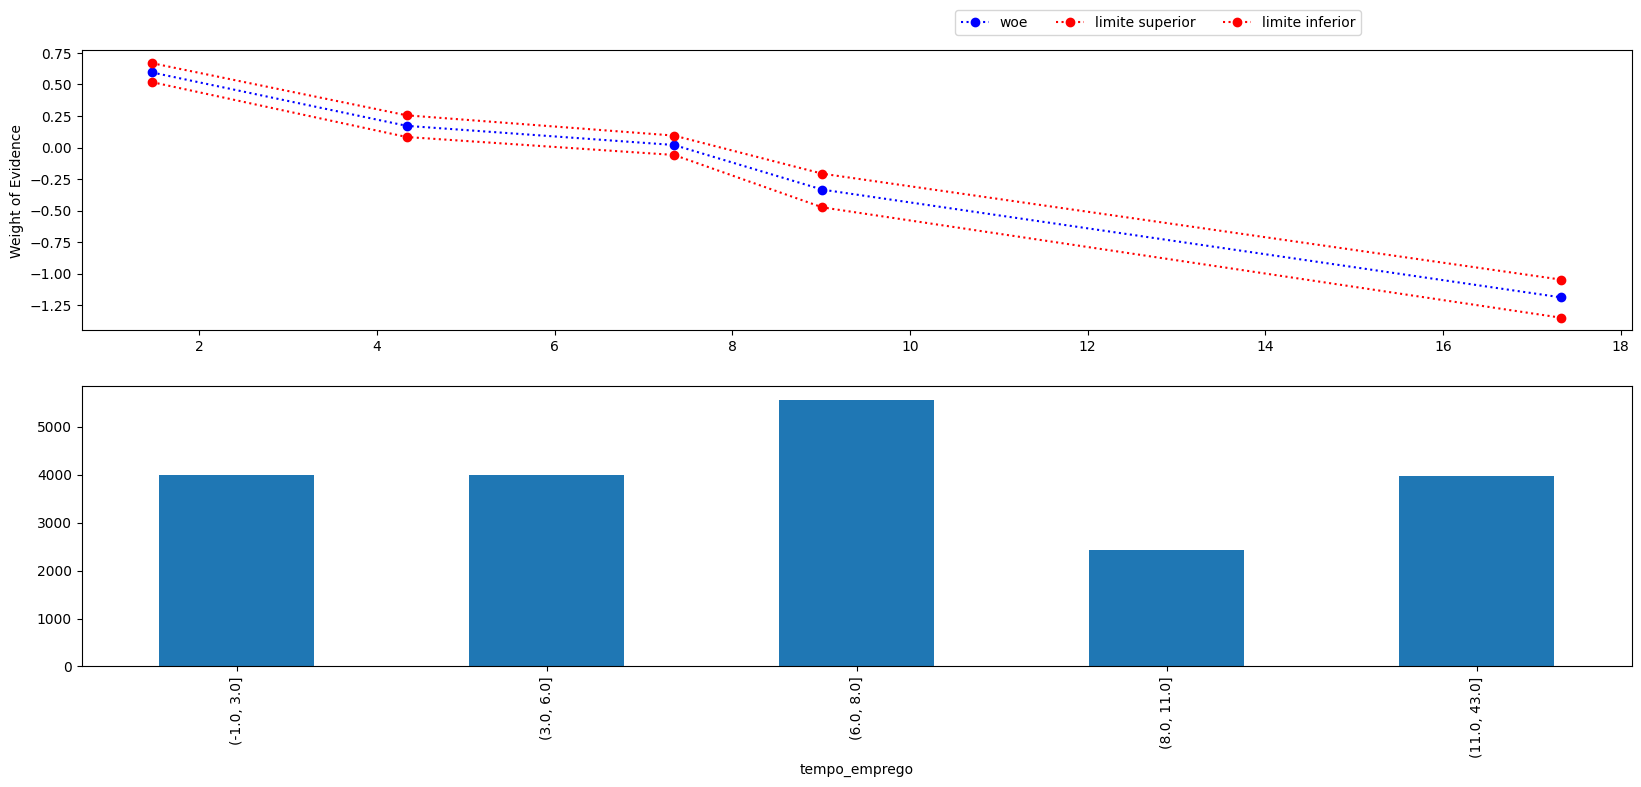

In [40]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


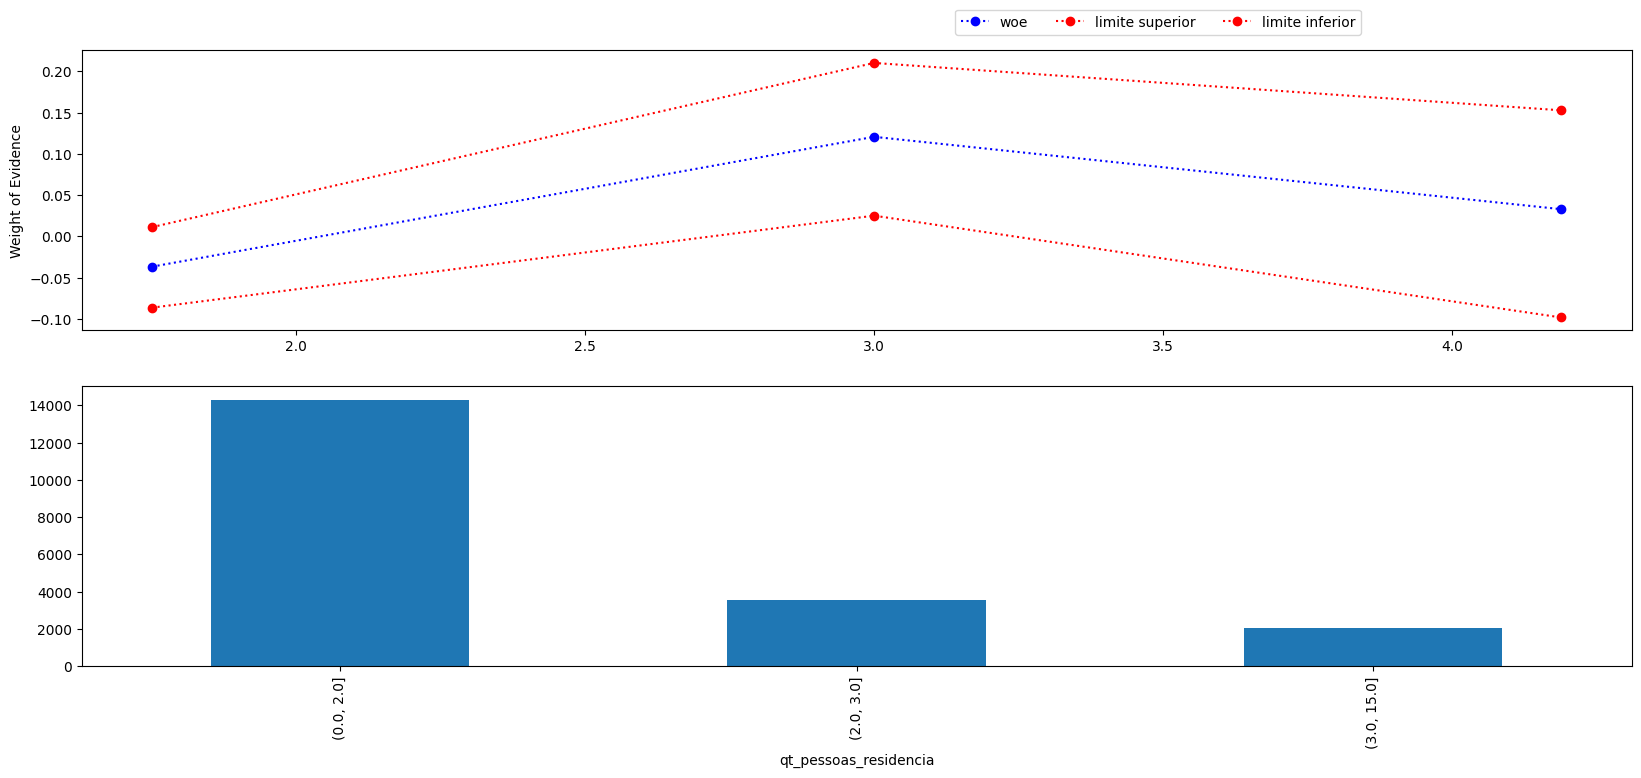

In [41]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


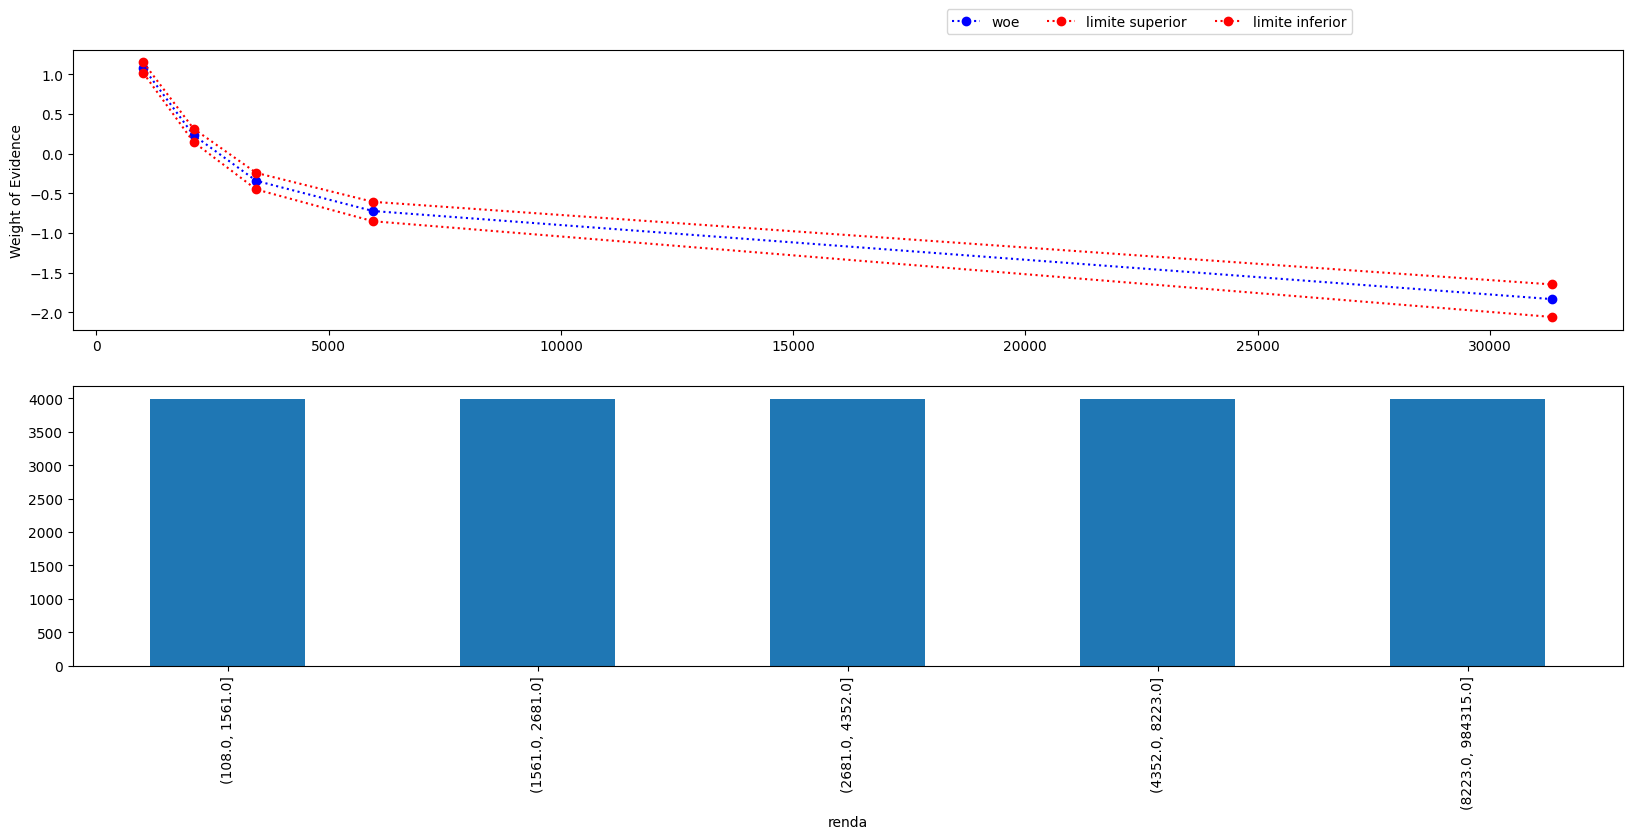

In [42]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


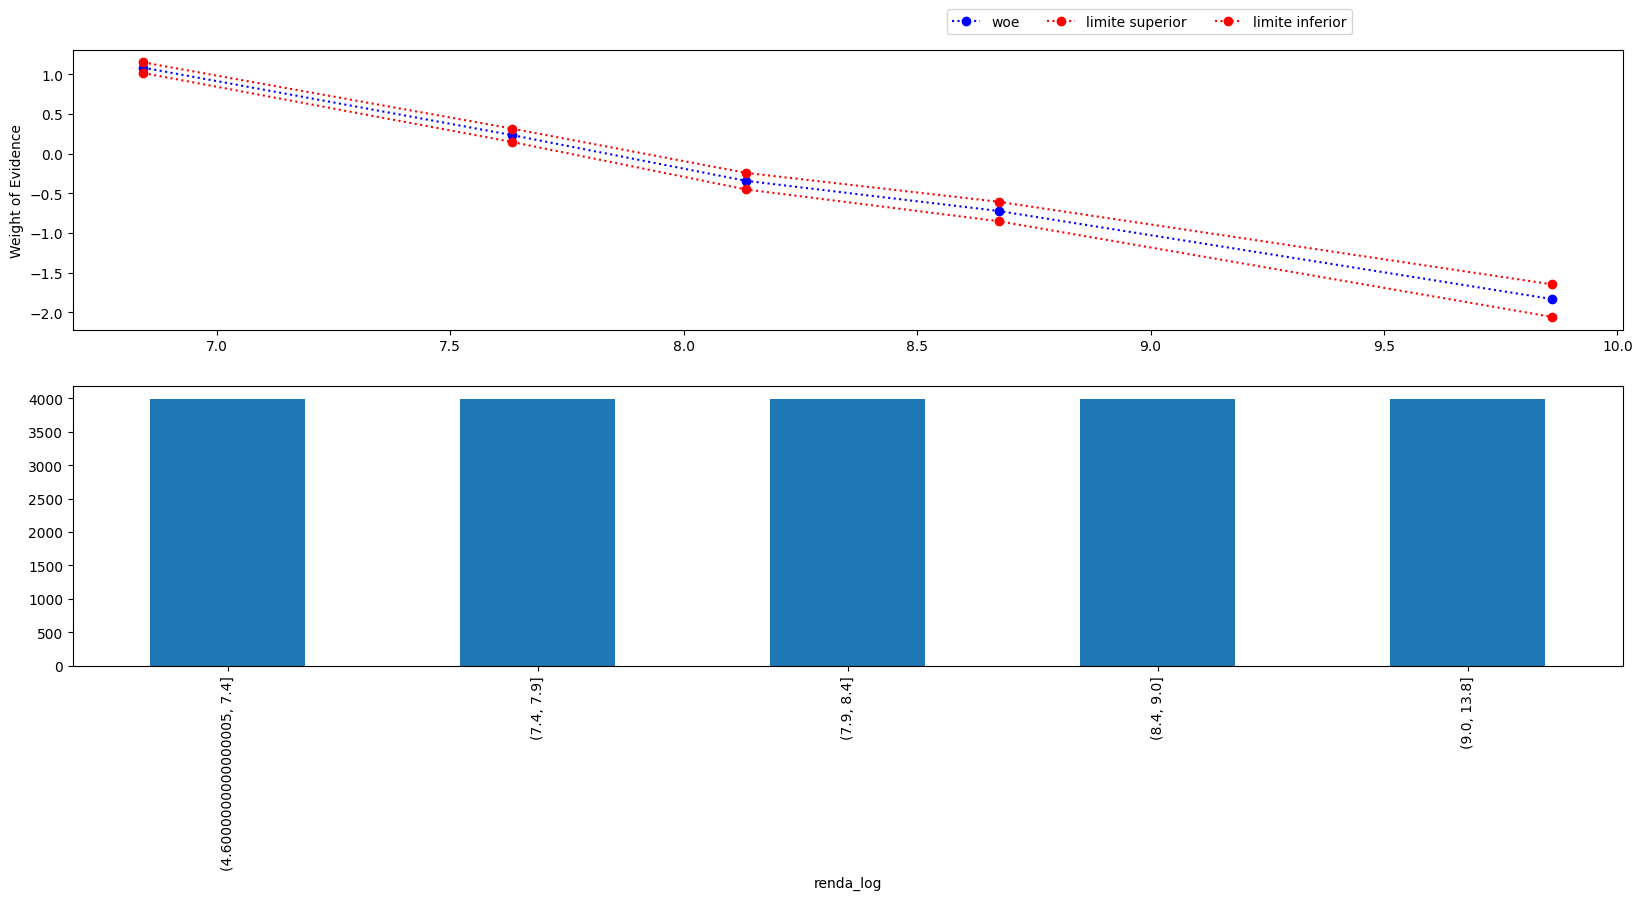

In [43]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

In [44]:
metadados_train = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados_train['nmissing'] = df_train.isna().sum()
metadados_train['valores_unicos'] = df_train.nunique()
metadados_train['papel'] = 'covariavel'
metadados_train.loc['mau','papel'] = 'resposta'
metadados_train

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,11,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


In [45]:
metadados_valid = pd.DataFrame(df_valid.dtypes, columns=['dtype'])
metadados_valid['nmissing'] = df_valid.isna().sum()
metadados_valid['valores_unicos'] = df_valid.nunique()
metadados_valid['papel'] = 'covariavel'
metadados_valid.loc['mau','papel'] = 'resposta'
metadados_valid

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,4,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [46]:
# Define a suavização dos dados na variável lowess
lowess_train = sm.nonparametric.lowess(df_train['renda_log'], df_train['tempo_emprego'], frac=1/9)
lowess_valid = sm.nonparametric.lowess(df_valid['renda_log'], df_valid['tempo_emprego'], frac=1/9)

# Valores de X e Y suavizados
f_train = interp1d(lowess_train[:, 0], lowess_train[:, 1], bounds_error=False)
f_valid = interp1d(lowess_valid[:, 0], lowess_valid[:, 1], bounds_error=False)

df_train.loc[:, 'tempo_emprego_lowess'] = f_train(df_train['tempo_emprego'])
df_valid.loc[:, 'tempo_emprego_lowess'] = f_valid(df_valid['tempo_emprego'])
df_train.head()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\866355704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'tempo_emprego_lowess'] = f_train(df_train['tempo_emprego'])
C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\866355704.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
138912,2015-03-01,F,N,S,2,Assalariado,Superior incompleto,Casado,Casa,29,5.958904,4.0,5713.75,True,8.650631,3,0,9.166177
85474,2015-02-01,M,S,N,0,Empresário,Médio,Casado,Casa,40,1.197260,2.0,1467.14,False,7.291070,2,1,8.566978
95328,2015-02-01,F,N,S,0,Empresário,Médio,Casado,Casa,62,7.619178,2.0,9044.93,False,9.109960,2,1,9.356375
539789,2015-11-01,F,N,N,1,Empresário,Superior completo,Casado,Casa,30,4.331507,3.0,6829.06,False,8.828942,11,1,8.967107
513818,2015-11-01,F,N,N,1,Assalariado,Médio,Separado,Casa,40,3.539726,2.0,12649.02,True,9.445335,11,0,8.852807


In [47]:
df_valid.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
630151,2016-01-01,F,N,N,1,Assalariado,Médio,Viúvo,Casa,53,1.295890,2.0,1214.39,False,7.101997,1,1,7.414109
590318,2015-12-01,F,S,S,0,Empresário,Médio,Casado,Casa,33,7.435616,2.0,12899.17,False,9.464918,12,1,8.273779
631627,2016-01-01,M,S,S,0,Empresário,Médio,Casado,Casa,42,0.860274,2.0,2412.85,False,7.788564,1,1,7.379808
659402,2016-02-01,F,N,N,0,Assalariado,Médio,Casado,Casa,50,3.178082,2.0,8460.85,False,9.043205,2,1,7.721659
565246,2015-12-01,F,S,S,2,Assalariado,Superior incompleto,Casado,Casa,31,0.276712,4.0,963.69,False,6.870770,12,1,7.332453


In [48]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~ 
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_train).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     8397.
Date:                Mon, 06 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:57:57   Log-Likelihood:                -72796.
No. Observations:               55055   AIC:                         1.456e+05
Df Residuals:                   55049   BIC:                         1.457e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -0.0788      0.047     -1.683      0.092      -0.171       0.013
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -0.0135      0.011     -1.233      0.217      -0.035       0.008
C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]             0.0363      0.190      0.191      0.848      -0.335       0.408
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]           0.1539      0.012     12.381      0.000       0.130       0.178
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]     0.1189      0.016      7.243      0.000       0.087       0.151
tempo_emprego_lowess                                            1.0022      0.005    200.059      0.000       0.992       1.012
==============================================================================
Omnibus:                      144.152   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.227
Skew:                          -0.113   Prob(JB):                     1.31e-31
Kurtosis:                       2.896   Cond. No.                         463.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# Sumário dos dados de treinamento do modelo
reg_redc_summary_frame = reg_redc.get_influence().summary_frame()
reg_redc_summary_frame.head()

,dfb_Intercept,"dfb_C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Empresário]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]",dfb_tempo_emprego_lowess,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
138912,-0.000623,-0.001504,-0.000010,-0.000027,-0.000115,0.000636,1.468148e-06,-0.488172,0.000037,-0.002968,-0.488168,-0.002968
85474,-0.005615,-0.000659,-0.000093,-0.008995,-0.001037,0.005732,3.560914e-05,-1.508643,0.000094,-0.014617,-1.508661,-0.014617
95328,0.000205,0.000024,0.000003,-0.002176,0.000038,-0.000209,1.884123e-06,-0.376514,0.000080,-0.003362,-0.376511,-0.003362
539789,-0.000400,-0.000047,-0.000007,-0.001505,-0.000074,0.000408,8.977166e-07,-0.256344,0.000082,-0.002321,-0.256341,-0.002321
513818,0.002177,0.002404,0.000036,0.000093,0.000402,-0.002223,3.982593e-06,0.733119,0.000044,0.004888,0.733116,0.004888


In [60]:
# Análise dos valores com maior peso no modelo
remov_index = reg_redc_summary_frame['hat_diag'].nlargest(23).index
remov_index

Index([ 99839, 197060, 148061, 400834,  16678, 352850, 484594,  30378, 216532,
       377898, 330681, 106092, 365431, 303320, 372003, 266701, 438482, 214302,
       336043, 514725, 458928,   6444, 221651],
      dtype='int64')

In [63]:
# Remoção dos valores ouliers com maior peso do modelo
df_train_outliers = df_train.drop(remov_index)
df_train_outliers.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
138912,2015-03-01,F,N,S,2,Assalariado,Superior incompleto,Casado,Casa,29,5.958904,4.0,5713.75,True,8.650631,3,0,9.166177
85474,2015-02-01,M,S,N,0,Empresário,Médio,Casado,Casa,40,1.197260,2.0,1467.14,False,7.291070,2,1,8.566978
95328,2015-02-01,F,N,S,0,Empresário,Médio,Casado,Casa,62,7.619178,2.0,9044.93,False,9.109960,2,1,9.356375
539789,2015-11-01,F,N,N,1,Empresário,Superior completo,Casado,Casa,30,4.331507,3.0,6829.06,False,8.828942,11,1,8.967107
513818,2015-11-01,F,N,N,1,Assalariado,Médio,Separado,Casa,40,3.539726,2.0,12649.02,True,9.445335,11,0,8.852807


In [64]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~ 
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_train_outliers).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                 1.049e+04
Date:                Mon, 06 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:18:01   Log-Likelihood:                -72766.
No. Observations:               55032   AIC:                         1.455e+05
Df Residuals:                   55027   BIC:                         1.456e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -0.0788      0.047     -1.683      0.092      -0.171       0.013
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -0.0135      0.011     -1.233      0.217      -0.035       0.008
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]           0.1539      0.012     12.381      0.000       0.130       0.178
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]     0.1189      0.016      7.243      0.000       0.087       0.151
tempo_emprego_lowess                                            1.0022      0.005    200.059      0.000       0.992       1.012
==============================================================================
Omnibus:                      144.068   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.156
Skew:                          -0.113   Prob(JB):                     1.35e-31
Kurtosis:                       2.897   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Salvando em disco o modelo e os registros de treinamento
dump(reg_redc_summary_frame, "./data/reg_redc_summary_frame")
dump(reg_redc, "./data/reg_redc")

['./data/reg_redc']

## Conclussão

- Trate valores missings e outliers
<br>R.: Valores missing foram substituídos pela média.

- Trate 'zeros estruturais'
<br>R.: Não foram encontrados zeros estruturais.

- Faça agrupamentos de categorias conforme vimos em aula
<br>R.: Não foi necessário agrupar categorias.

- Proponha uma equação preditiva para 'mau'
<br>R,: Equação mais eficiente usa tempo de emprego suavizado e tipo de renda com cazela de Pnesionista

- Caso hajam categorias não significantes, justifique
<br>R.: Categorias não significativas foram resolvidas com a retirada dos outliers.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

Treino

In [71]:
# Obtenção da predição na base de treino
df_train_outliers['y_pred'] = reg_redc.predict(df_train_outliers)
y_pred = df_train_outliers['y_pred']
y_true = df_train_outliers['renda_log']

In [73]:
# KS
ks_2samp(y_true, y_pred)

KstestResult(statistic=0.20444468672772206, pvalue=0.0, statistic_location=8.368038676611757, statistic_sign=1)

In [74]:
# Gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(y_pred)

0.04217837276918701

Validação

In [79]:
# Removendo uma das categorias da base de validação, que não está presente no teste
df_valid = df_valid[~(df_valid['tipo_renda'] == "Bolsista")]
df_valid['tipo_renda'].value_counts()

tipo_renda
Assalariado         10362
Empresário           4555
Pensionista          3326
Servidor público     1691
Name: count, dtype: int64

In [80]:
# Obtenção da predição na base de treino
df_valid['y_pred'] = reg_redc.predict(df_valid)
y_pred = df_valid['y_pred']
y_true = df_valid['renda_log']

C:\Users\gfsil\AppData\Local\Temp\ipykernel_13248\2741305189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['y_pred'] = reg_redc.predict(df_valid)


In [81]:
# KS
ks_2samp(y_true, y_pred)

KstestResult(statistic=0.1707635196147286, pvalue=1.4084815742779991e-254, statistic_location=7.25429806553826, statistic_sign=1)

In [82]:
# Gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(y_pred)

0.04881381786780892

### Conclusão
- Não foram observadas diferenças significativas entre a base de treino e a de validação
  
|Base|KS|Gini|
|-|-|-|
|Treino|0.204|0.042|
|Validação|0.17|0.049|

- Não é possível obter a acurácia de um modelo de predição para variável contínua